Aaron Chien

405498016

# Project 3 - Classify your own data

For this project we're going to explore some of the new topics since the last project including Decision Trees and Un-supervised learning. The final part of the project will ask you to perform your own data science project to classify a new dataset.



## Submission Details

**Project is due June 14th at 11:59 am (Wednesday Afternoon). To submit the project, please save the notebook
as a pdf file and submit the assignment via Gradescope. In addition, make sure that
all figures are legible and suﬀiciently large. For best pdf results, we recommend downloading [Latex](https://www.latex-project.org/) and print the notebook using Latex.**

## Loading Essentials and Helper Functions 

In [1]:
#Here are a set of libraries we imported to complete this assignment. 
#Feel free to use these or equivalent libraries for your implementation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # this is used for the plot the graph 
import matplotlib
import os
import time
#Sklearn classes
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix,silhouette_score
import sklearn.metrics.cluster as smc
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder ,LabelEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_blobs

from matplotlib import pyplot
import itertools

%matplotlib inline

#Sets random seed
import random 
random.seed(42) 

In [2]:
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import math

In [3]:
#Helper functions
def draw_confusion_matrix(y, yhat, classes):
    '''
        Draws a confusion matrix for the given target and predictions
        Adapted from scikit-learn and discussion example.
    '''
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.YlOrBr)
    plt.title("Confusion Matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=0)
    plt.yticks(np.arange(num_classes), classes)
    plt.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)    
    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.gca().xaxis.set_label_position('top')
    plt.tight_layout()
    plt.show()
    
def heatmap(data, row_labels, col_labels, figsize = (20,12), cmap = "YlGn",
            cbar_kw={}, cbarlabel="", valfmt="{x:.2f}",
            textcolors=("black", "white"), threshold=None):
    """
    Create a heatmap from a numpy array and two lists of labels. 
    
    Taken from matplotlib example.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cmap
        A string that specifies the colormap to use. Look at matplotlib docs for information.
        Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
    """

    plt.figure(figsize = figsize)
    ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data,cmap=cmap)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    
    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)


def make_meshgrid(x, y, h=0.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    return out

def draw_contour(x,y,clf, class_labels = ["Negative", "Positive"]):
    """
    Draws a contour line for the predictor
    
    Assumption that x has only two features. This functions only plots the first two columns of x.
    
    """
    
    X0, X1 = x[:, 0], x[:, 1]
    xx0, xx1 = make_meshgrid(X0,X1)
    
    plt.figure(figsize = (10,6))
    plot_contours(clf, xx0, xx1, cmap="PiYG", alpha=0.8)
    scatter=plt.scatter(X0, X1, c=y, cmap="PiYG", s=30, edgecolors="k")
    plt.legend(handles=scatter.legend_elements()[0], labels=class_labels)

    plt.xlim(xx0.min(), xx0.max())
    plt.ylim(xx1.min(), xx1.max())
    


# Example Project using new techniques 

Since project 2, we have learned about a few new models for supervised learning(Decision Trees and Neural Networks) and un-supervised learning (Clustering and PCA). In this example portion, we will go over how to implement these techniques using the Sci-kit learn library.

## Load and Process Example Project Data


For our example dataset, we will use the [Breast Cancer Wisconsin Dataset](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data) to determine whether a mass found in a body is benign or malignant. Since this dataset was used as an example in project 2, you should be fairly familiar with it.

Feature Information:

Column 1: ID number

Column 2: Diagnosis (M = malignant, B = benign)

Ten real-valued features are computed for each cell nucleus:

    1. radius (mean of distances from center to points on the perimeter)
    2. texture (standard deviation of gray-scale values)
    3. perimeter
    4. area
    5. smoothness (local variation in radius lengths)
    6. compactness (perimeter^2 / area - 1.0)
    7. concavity (severity of concave portions of the contour)
    8. concave points (number of concave portions of the contour)
    9. symmetry
    10. fractal dimension ("coastline approximation" - 1)

Due to the statistical nature of the test, we are not able to get exact measurements of the previous values. Instead, the dataset contains the mean and standard error of the real-valued features. 

Columns 3-12 present the mean of the measured values

Columns 13-22 present the standard error of the measured values

In [4]:
#Preprocess Data

#Load Data
data = pd.read_csv('datasets/breast_cancer_data.csv')

#Drop id column
data = data.drop(["id"],axis= 1)

#Transform target feature into numerical
le = LabelEncoder() 
data['diagnosis'] = le.fit_transform(data['diagnosis'])

#Split target and data
y = data["diagnosis"]
x = data.drop(["diagnosis"],axis = 1)

#Train test split
train_raw, test_raw, target, target_test = train_test_split(x,y, test_size=0.2, stratify= y, random_state=0)

#Standardize data
#Since all features are real-valued, we only have one pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler())
])

#Transform raw data 
train = pipeline.fit_transform(train_raw)
test = pipeline.transform(test_raw) #Note that there is no fit calls

#Names of Features after Pipeline
feature_names = list(pipeline.get_feature_names_out(list(x.columns)))

In [5]:
target.value_counts()

0    285
1    170
Name: diagnosis, dtype: int64

In [6]:
#Baseline accuracy of using the majority class 
ct = target_test.value_counts()
print("Counts of each class in target_test: ")
print(ct)
print("Baseline Accuraccy of using Majority Class: ", np.max(ct)/np.sum(ct))

Counts of each class in target_test: 
0    72
1    42
Name: diagnosis, dtype: int64
Baseline Accuraccy of using Majority Class:  0.631578947368421


## Supervised Learning: Decision Tree


### Classification with Decision Tree

In [7]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state = 0)
clf.fit(train, target)
predicted = clf.predict(test)

Accuracy:    0.894737
Confusion Matrix: 
 [[63  9]
 [ 3 39]]


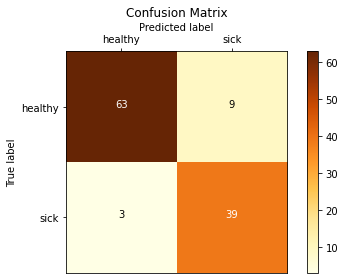

In [8]:
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))
draw_confusion_matrix(target_test, predicted, ['healthy', 'sick'])

###  Parameters for Decision Tree Classifier

In Sci-kit Learn, the following are just some of the parameters we can pass into the Decision Tree Classifier:

- criterion: {‘gini’, ‘entropy’, ‘log_loss’} default="gini"
    - The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “log_loss” and “entropy” both for the Shannon information gain 
- splitter: {“best”, “random”}, default=”best”
    - The strategy used to choose the split at each node. “best” aims to find the best feature split amongst all features. "random" only looks for the best split amongst a random subset of features.
- max_depth: int, default = 2 {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’
    - The maximum depth of the tree.
- min_samples_split: int or float, default=2
    - The minimum number of samples required to split an internal node. If int, then consider min_samples_split as the minimum number. If float, then min_samples_split is a fraction and ceil(min_samples_split * n_samples) are the minimum number of samples for each split.

### Visualizing Decision Trees

Scikit-learn allows us to visualize the decision tree to see what features it choose to split and what the result is. Note that if the condition in the node is true, you traverse the left edge of the node. Otherwise, you traverse the right edge.

[Text(0.5, 0.8333333333333334, 'concave points_mean <= 0.011\ngini = 0.468\nsamples = 100.0%\nvalue = [0.626, 0.374]'),
 Text(0.25, 0.5, 'area_mean <= 0.124\ngini = 0.101\nsamples = 61.5%\nvalue = [0.946, 0.054]'),
 Text(0.125, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.375, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.75, 0.5, 'concavity_mean <= 0.001\ngini = 0.202\nsamples = 38.5%\nvalue = [0.114, 0.886]'),
 Text(0.625, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.875, 0.16666666666666666, '\n  (...)  \n')]

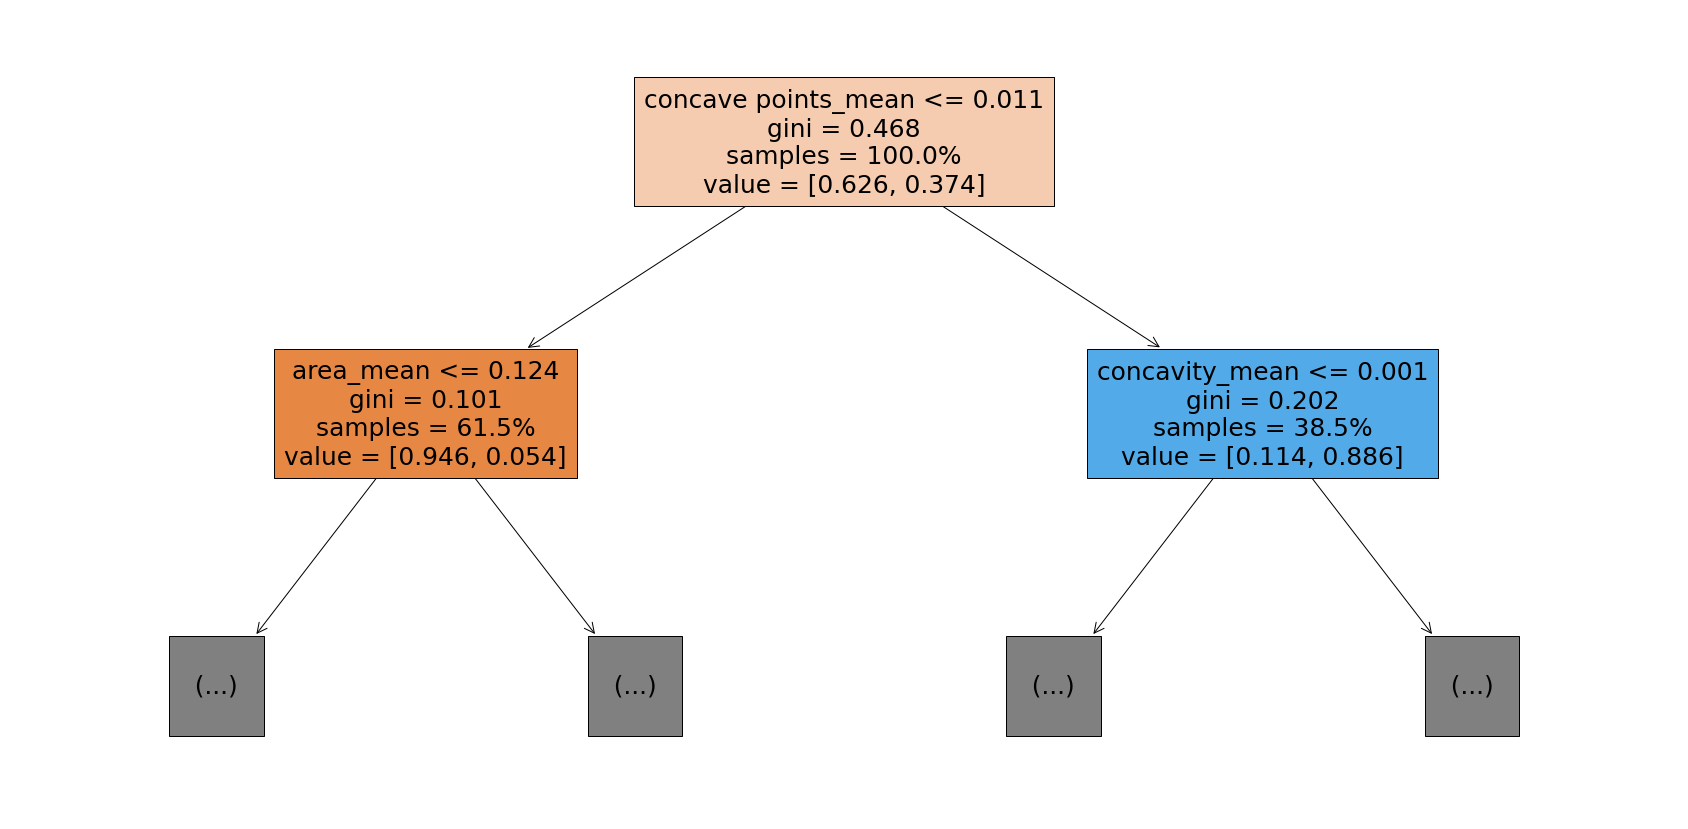

In [9]:
plt.figure(figsize = (30,15)) 
#Note that we have to pass the feature names into the plotting function to get the actual names
#We pass the column names through the pipeline in case any feature augmentation was made
#For example, a categorical feature will be split into multiple features with one hot encoding
#and this way assigns a name to each column based on the feature value and the original feature name
tree.plot_tree(clf,max_depth=1, proportion=True,feature_names=feature_names, filled=True)

We can even look at the tree in a textual format.

In [10]:
from sklearn.tree import export_text
r = export_text(clf, feature_names=feature_names)
print(r)

|--- concave points_mean <= 0.01
|   |--- area_mean <= 0.12
|   |   |--- area_se <= 0.04
|   |   |   |--- compactness_mean <= 0.59
|   |   |   |   |--- fractal_dimension_se <= -0.83
|   |   |   |   |   |--- fractal_dimension_se <= -0.84
|   |   |   |   |   |   |--- smoothness_se <= -1.22
|   |   |   |   |   |   |   |--- compactness_se <= -0.98
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- compactness_se >  -0.98
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- smoothness_se >  -1.22
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- fractal_dimension_se >  -0.84
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- fractal_dimension_se >  -0.83
|   |   |   |   |   |--- class: 0
|   |   |   |--- compactness_mean >  0.59
|   |   |   |   |--- symmetry_se <= 0.20
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- symmetry_se >  0.20
|   |   |   |   |   |--- class: 0
|   |   |--- area_se >  0.04
|   |   |   

### Feature Importance in Decision Trees

Decision Trees can also assign importance to features by measuring the average decrease in impurity (i.e. information gain) for each feature. The features with higher decreases are treated as more important. 

<AxesSubplot:>

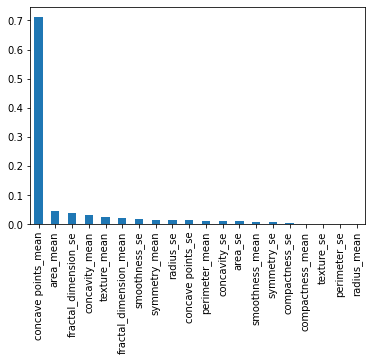

In [11]:
imp_pd = pd.Series(data = clf.feature_importances_ ,index = feature_names)
imp_pd= imp_pd.sort_values(ascending=False)
imp_pd.plot.bar()

We can clearly see that "concave points_mean" has the largest importance due to it providing the most reduction in the impurity.

### Visualizing decision boundaries for Decision Trees

Similar to project 2, lets see what decision boundaries that a Decision Tree creates. We use the two most correlated features to the target labels: concave_points_mean and perimeter_mean. 

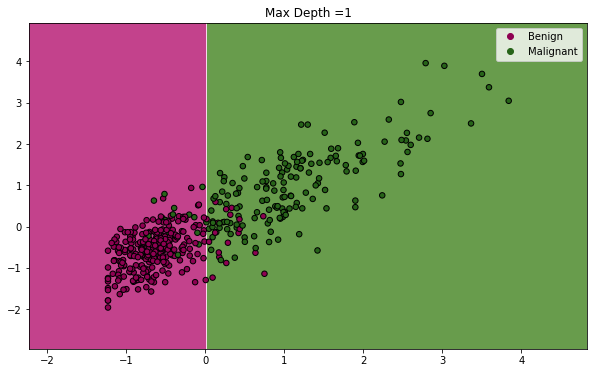

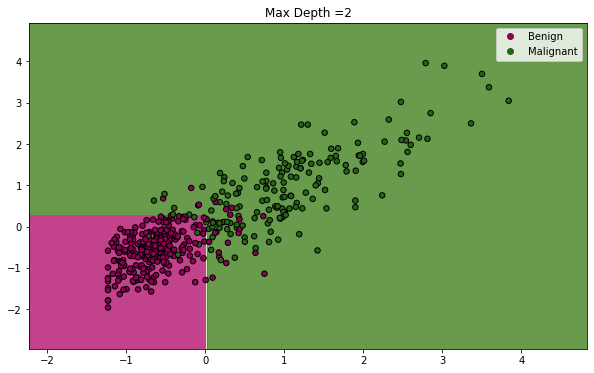

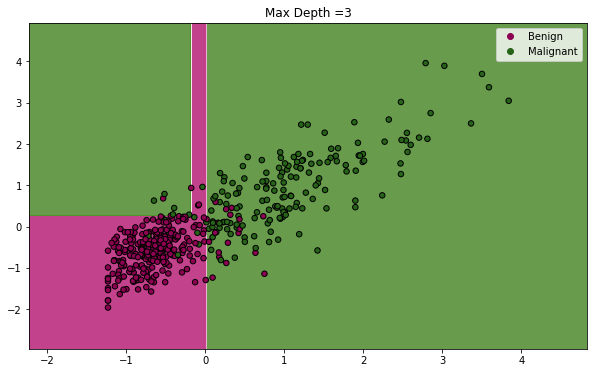

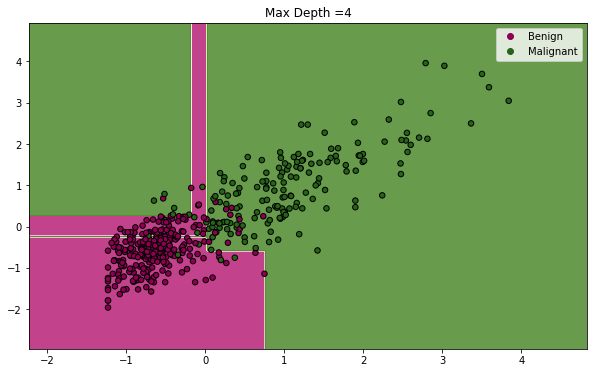

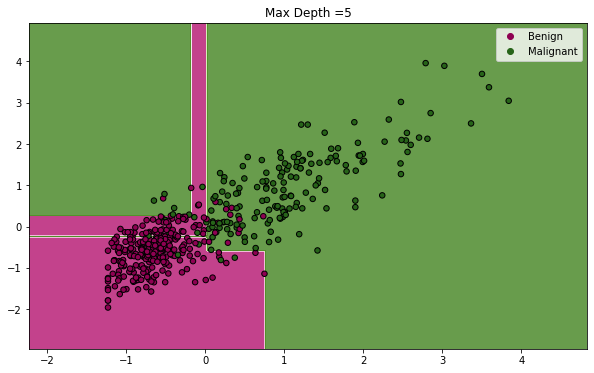

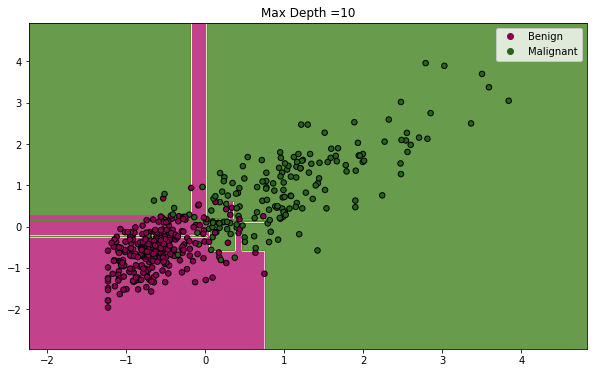

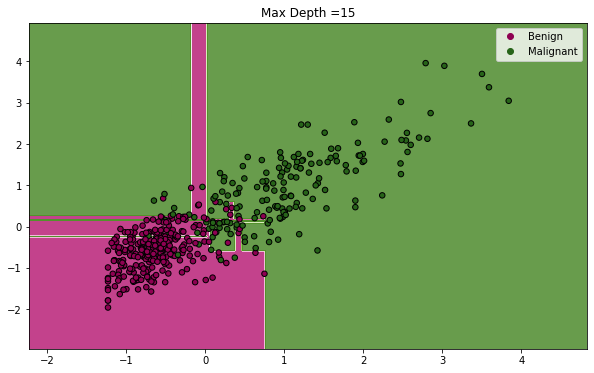

In [12]:
#Extract first two feature and use the standardscaler 
train_2 = StandardScaler().fit_transform(train_raw[['concave points_mean','perimeter_mean']])

depth  = [1,2,3,4,5,10,15]
for d in depth:
    dt = DecisionTreeClassifier(max_depth = d, min_samples_split=7) 
    dt.fit(train_2, target)
    draw_contour(train_2,target,dt,class_labels = ['Benign', 'Malignant'])
    
    plt.title(f"Max Depth ={d}")

We can see that the model gets more and more complex with increasing depth until it converges somewhere in between depth 10 and 15. 

## Supervised Learning: Multi-Layer Perceptron (MLP)

A neural network is a series of algorithms that endeavors to recognize underlying relationships in a set of data through a process that mimics the way the human brain operates. Neural networks are very powerful tools that are used a in a variety of applications including image and speech processing. In class, we have discussed one of the earliest types of neural networks known as a Multi-Layer Perceptron. 

![steps](jupyter_images/mlp_example.png)

### Using MLP for classification

In [13]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter = 400)
clf.fit(train, target)
predicted = clf.predict(test)

/Users/aaron/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy:    0.929825
Confusion Matrix: 
 [[65  7]
 [ 1 41]]


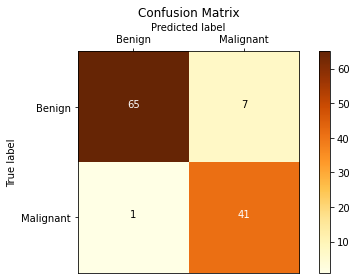

In [14]:
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))
draw_confusion_matrix(target_test, predicted, ['Benign', 'Malignant'])

###  Parameters for MLP Classifier

In Sci-kit Learn, the following are just some of the parameters we can pass into MLP Classifier:

- hidden_layer_sizes: tuple, length = n_layers - 2, default=(100,)
    - The ith element represents the number of neurons in the ith hidden layer. 
- activation: {‘identity’, ‘logistic’, ‘tanh’, ‘relu’}, default=’relu’
    - Activation function for the hidden layer.
- alpha: float, default = 0.0001
    - Strength of the L2 regularization term. The L2 regularization term is divided by the sample size when added to the loss.
- max_iter: int, default=200
    - Maximum number of iterations taken for the solvers to converge.

### Visualizing decision boundaries for MLP

Now, lets see how the decision boundaries change as a function of both the activation function and the number of hidden layers.

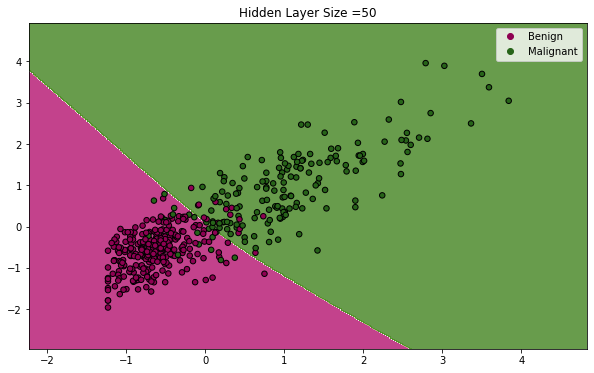

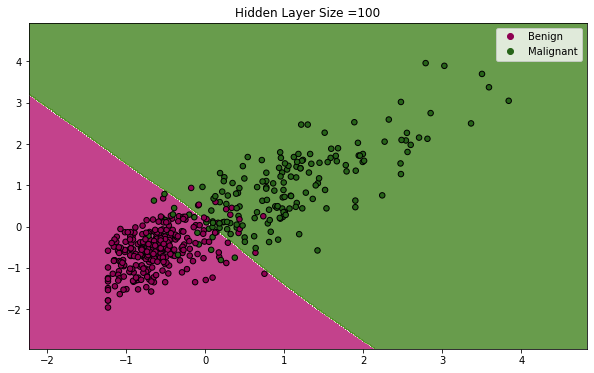

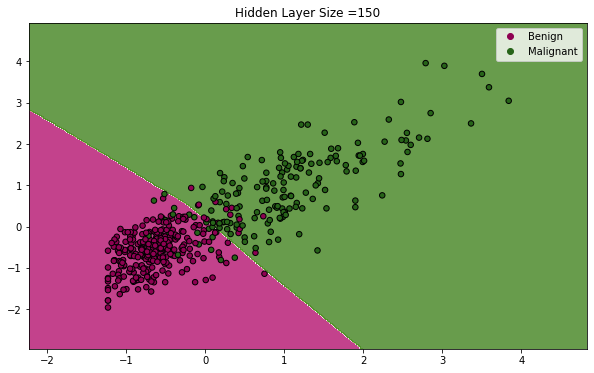

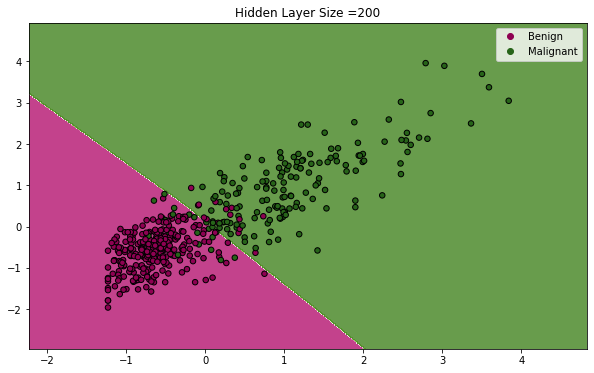

In [15]:
#Example of using the default Relu activation while altering the number of hidden layers
train_2 = StandardScaler().fit_transform(train_raw[['concave points_mean','perimeter_mean']])

layers  = [50,100,150,200]
for l in layers:
    mlp = MLPClassifier(hidden_layer_sizes=(l,), max_iter = 400)
    mlp.fit(train_2, target)
    draw_contour(train_2,target,mlp,class_labels = ['Benign', 'Malignant'])
    
    plt.title(f"Hidden Layer Size ={l}")

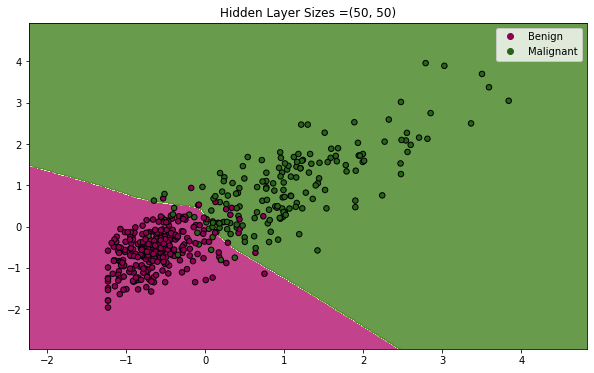

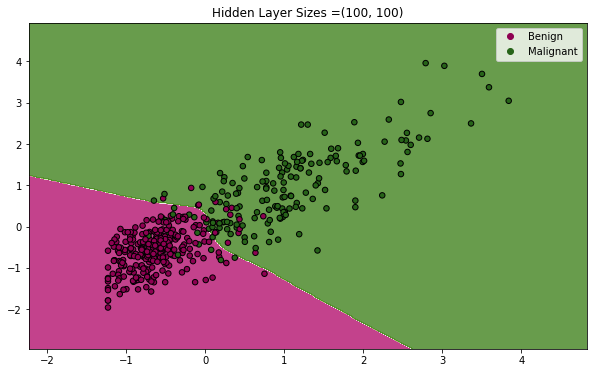

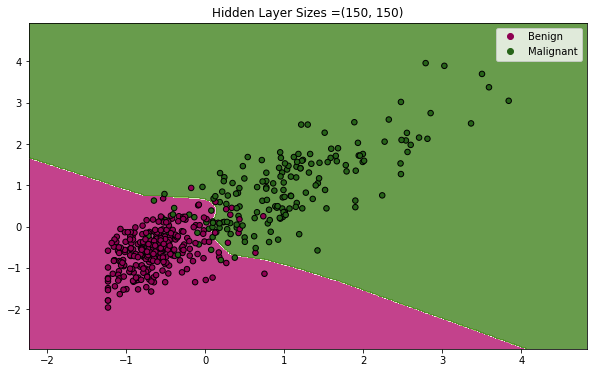

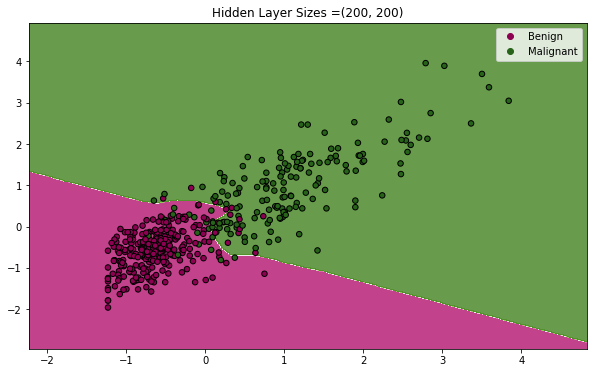

In [16]:
#Example of using the default Relu activation 
#while altering the number of hidden layers with 2 groups of hidden layers
train_2 = StandardScaler().fit_transform(train_raw[['concave points_mean','perimeter_mean']])

layers  = [50,100,150,200]
for l in layers:
    mlp = MLPClassifier(hidden_layer_sizes=(l,l), max_iter = 400)
    mlp.fit(train_2, target)
    draw_contour(train_2,target,mlp,class_labels = ['Benign', 'Malignant'])
    
    plt.title(f"Hidden Layer Sizes ={(l,l)}")

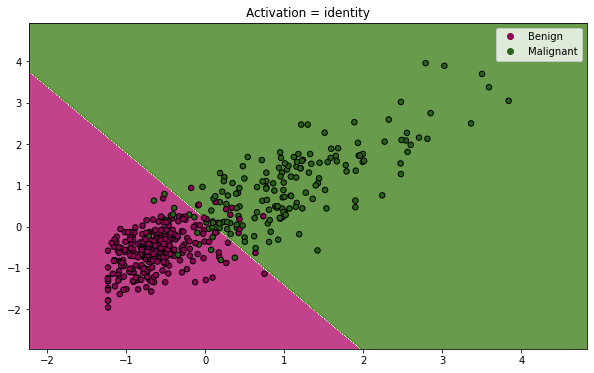

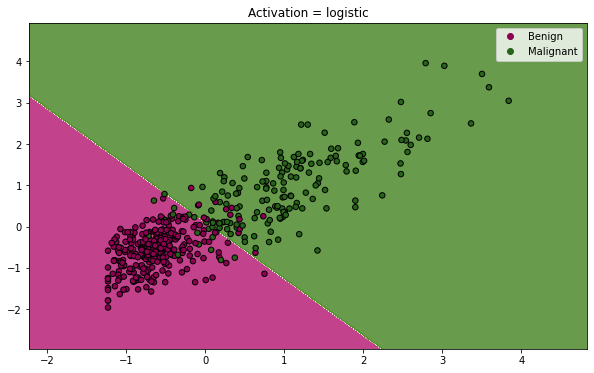

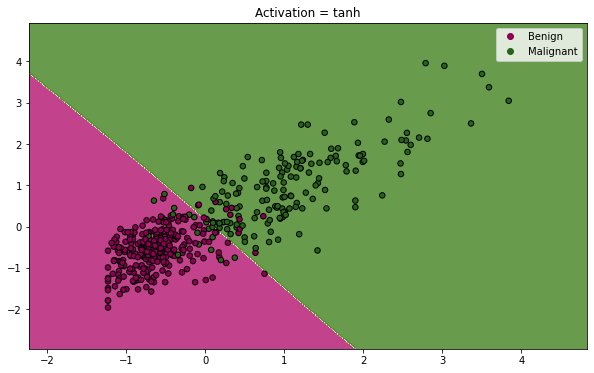

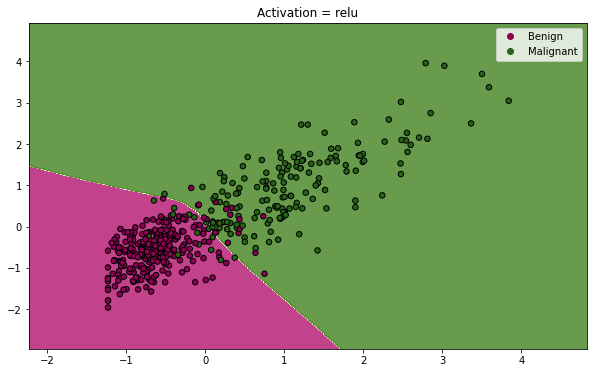

In [17]:
#Example of using 2 hidden layers of 100 units each with varying activations
train_2 = StandardScaler().fit_transform(train_raw[['concave points_mean','perimeter_mean']])

acts  = ['identity', 'logistic', 'tanh', 'relu']
for act in acts:
    mlp = MLPClassifier(hidden_layer_sizes=(100,100), activation = act, max_iter = 400)
    mlp.fit(train_2, target)
    draw_contour(train_2,target,mlp,class_labels = ['Benign', 'Malignant'])
    
    plt.title(f"Activation = {act}")

## Unsupervised learning: PCA

As shown in lecture, PCA is a valuable dimensionality reduction tool that can extract a small subset of valuable features. In this section, we shall demonstrate how PCA can extract important visual features from pictures of subjects faces. We shall use the [AT&T Database of Faces](https://www.kaggle.com/datasets/kasikrit/att-database-of-faces). This dataset contains 40 different subjects with 10 samples per subject which means we a dataset of 400 samples. 

We extract the images from the [scikit-learn dataset library](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html#sklearn.datasets.fetch_olivetti_faces). The library imports the images (faces.data), the flatten array of images (faces.images), and which subject eacj image belongs to (faces.target). Each image is a 64 by 64 image with pixels converted to floating point values in [0,1].

### Eigenfaces

The following codes downloads and loads the face data. 

In [18]:
#Import faces from scikit library
faces = datasets.fetch_olivetti_faces()
print("Flattened Face Data shape:", faces.data.shape)
print("Face Image Data Shape:", faces.images.shape)
print("Shape of target data:", faces.target.shape)


Flattened Face Data shape: (400, 4096)
Face Image Data Shape: (400, 64, 64)
Shape of target data: (400,)


In [19]:
#Extract image shape for future use
im_shape = faces.images[0].shape

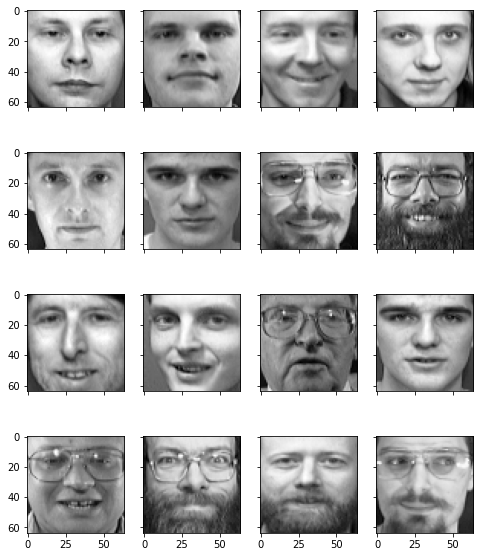

In [20]:
#Prints some example faces 
faceimages = faces.images[np.random.choice(len(faces.images),size= 16, replace = False)] # take random 16 images

fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,10))
for i in range(16):
    axes[i%4][i//4].imshow(faceimages[i], cmap="gray")
plt.show()

Now, let us see what features we can extract from these face images.

In [21]:
#Perform PCA
from sklearn.decomposition import PCA
 
pca = PCA()
pca_pipe = Pipeline([("scaler",StandardScaler()), 
                     #Scikit learn PCA does not standardize so we need to add
               ("pca",pca)])
pca_pipe.fit(faces.data)


Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA())])

The following plots the top 30 PCA components with how much variance does this feature explain.

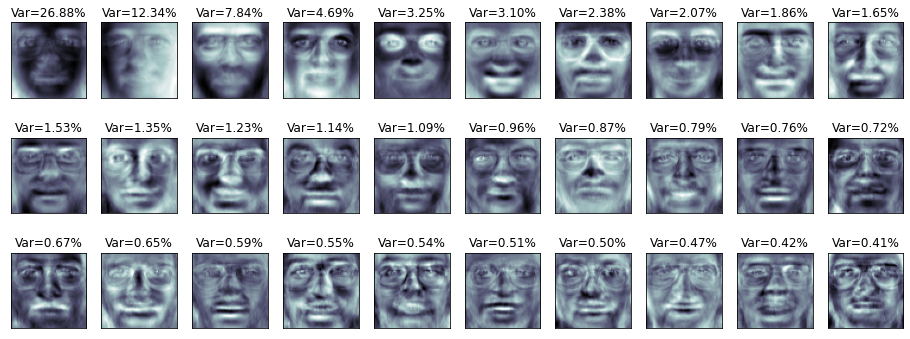

In [22]:
fig = plt.figure(figsize=(16, 6))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(im_shape),
              cmap=plt.cm.bone)
    ax.set_title(f"Var={pca.explained_variance_ratio_[i]:.2%}")
    

Amazing! We can see that the model has learned to focus on many features that we as humans also look at when trying to identify a face such as the nose,eyes, eyebrows, etc.

With this feature extraction, we can perform much more powerful learning. 

### Feature Extraction for Classification

Lets see if we can use PCA to improve the accuracy of the decision tree classifier.

Accuracy without PCA
Accuracy:    0.894737
Confusion Matrix: 
 [[63  9]
 [ 3 39]]


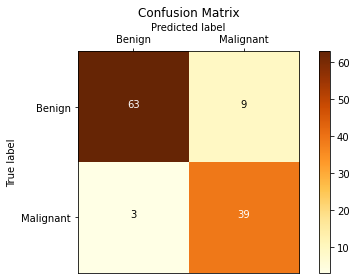

Accuracy with PCA
Accuracy:    0.912281
Confusion Matrix: 
 [[66  6]
 [ 4 38]]


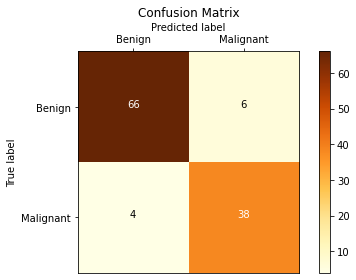

In [23]:
#Without PCA
clf = DecisionTreeClassifier(random_state=0)
clf.fit(train, target)
predicted = clf.predict(test)

print("Accuracy without PCA")
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))
draw_confusion_matrix(target_test, predicted, ['Benign', 'Malignant'])

#With PCA
pca = PCA(n_components = 0.9) #Take components that explain at lest 90% variance
       
train_new = pca.fit_transform(train)
test_new = pca.transform(test)

clf_pca = DecisionTreeClassifier(random_state=0)
clf_pca.fit(train_new, target)
predicted = clf_pca.predict(test_new)

print("Accuracy with PCA")
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))
draw_confusion_matrix(target_test, predicted, ['Benign', 'Malignant'])


In [24]:
print("Number of Features without PCA: ", train.shape[1])
print("Number of Features with PCA: ", train_new.shape[1])

Number of Features without PCA:  20
Number of Features with PCA:  7


Clearly, we get a much better accuracy for the model while using fewer features. But does the features the PCA thought were important the same features that the decision tree used. Lets look at the feature importance of the tree. The following plot numbers the first principal component as 0, the second as 1, and so forth.

<AxesSubplot:>

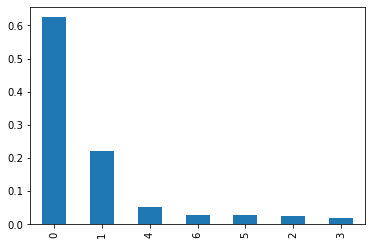

In [25]:
feature_names_new = list(range(train_new.shape[1]))
imp_pd = pd.Series(data = clf_pca.feature_importances_ ,index = feature_names_new)
imp_pd= imp_pd.sort_values(ascending=False)
imp_pd.plot.bar()


Amazingly, the first and second components were the most important features in the decision tree. Thus, we can claim that PCA has significantly improved the performance of our model. 

## Unsupervised learning: Clustering

Clustering is the task of grouping a set of objects in such a way that objects in the same group (called a cluster) are more similar (in some sense) to each other than to those in other groups. One major algorithm we learned in class is the K-Means algorithm.

### Evaluating K-Means performance

While there are many ways to evaluate the [performance measure of clustering algorithsm](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation), we will focus on the inertia score of the K-Means model. Inertia is another term for the sum of squared distances of samples to their closest cluster center. 

Let us look at how the Inertia changes as a function of the number of clusters for an artificial dataset.


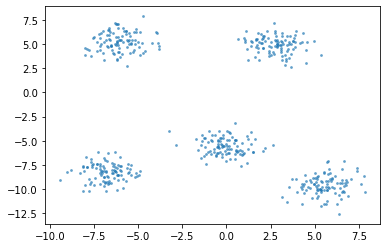

In [26]:
#Artifical Dataset
X, y = make_blobs(
    n_samples=500,
    n_features=2,
    centers=5,
    cluster_std=1,
    center_box=(-10.0, 10.0),
    shuffle=True,
    random_state=10,
)  # For reproducibility

plt.scatter(X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7,edgecolor="k")


In [27]:
ks = list(range(2,10))
inertia = []
for k in ks:
    kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state = 0)
    kmeans.fit(X)
    # inertia method returns wcss for that model
    inertia.append(kmeans.inertia_)
    print(f"Inertia for K = {k}: {kmeans.inertia_}")
    

Inertia for K = 2: 13293.99746096155
Inertia for K = 3: 7169.578996856774
Inertia for K = 4: 3247.8674040695832
Inertia for K = 5: 872.8554968701876
Inertia for K = 6: 803.8466864258228
Inertia for K = 7: 739.5236191503765
Inertia for K = 8: 690.2530283275607
Inertia for K = 9: 614.5138307338652


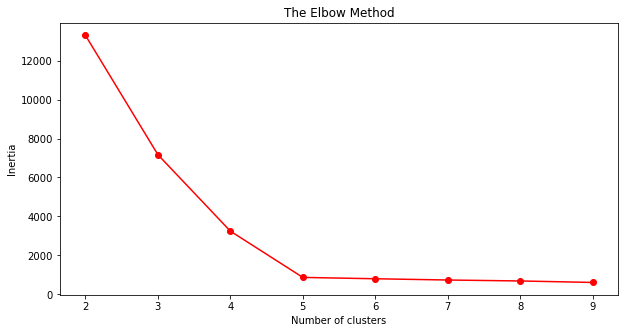

In [28]:
plt.figure(figsize=(10,5))
plt.plot(ks, inertia,marker='o',color='red')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


From the plot, we can see that when the number of clusters of K-means is the correct number of clusters, Inertia starts decreasing at a much slower rate. This creates a kind of elbow shape in the graph. For K-means clustering, the elbow method selects the number of clusters where the elbow shape is formed. In this case, we see that this method would produce the correct number of clusters.

Lets try it on the cancer dataset.

In [29]:
ks = list(range(2,30))
inertia = []
for k in ks:
    kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state = 0)
    kmeans.fit(train)
    # inertia method returns wcss for that model
    inertia.append(kmeans.inertia_)
    print(f"Inertia for K = {k}: {kmeans.inertia_}")
    

Inertia for K = 2: 6381.27832595592
Inertia for K = 3: 5508.621446593708
Inertia for K = 4: 4972.231721973119
Inertia for K = 5: 4507.2671373660705
Inertia for K = 6: 4203.777246823878
Inertia for K = 7: 3942.6595508964115
Inertia for K = 8: 3745.1124228292674
Inertia for K = 9: 3532.7225156022064
Inertia for K = 10: 3371.033467027838
Inertia for K = 11: 3232.4727580707367
Inertia for K = 12: 3135.1944201924525
Inertia for K = 13: 3033.3838427786477
Inertia for K = 14: 2958.3200036360377
Inertia for K = 15: 2893.798763511904
Inertia for K = 16: 2767.804761705547
Inertia for K = 17: 2737.4747101790635
Inertia for K = 18: 2662.1203080706655
Inertia for K = 19: 2617.9089069400507
Inertia for K = 20: 2553.961378449725
Inertia for K = 21: 2491.9133737078346
Inertia for K = 22: 2448.7776236009963
Inertia for K = 23: 2391.6445885404164
Inertia for K = 24: 2374.1345787190176
Inertia for K = 25: 2334.7940109810734
Inertia for K = 26: 2267.9935217066172
Inertia for K = 27: 2233.585453239128
Iner

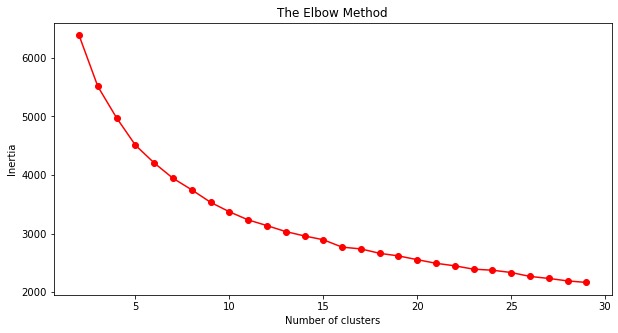

In [30]:
plt.figure(figsize=(10,5))
plt.plot(ks, inertia,marker='o',color='red')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


Here we see that the elbow is not as cleanly defined. This may be due to the dataset not being a good fit for K-means. Regardless, we can still apply the elbow method by noting that the slow down happens around 7~14.

### Kmeans on Eigenfaces

Now, lets see how K-means performs in clustering the face data with PCA.

In [31]:
from sklearn.cluster import KMeans

n_clusters = 10 #We know there are 10 subjects
km = KMeans(n_clusters  = n_clusters,random_state=0)

pipe= Pipeline([("scaler",StandardScaler()), #First standardize
               ("pca",PCA()), #Transform using pca
         ("kmeans", km )]) #Then apply k means


In [32]:
clusters = pipe.fit_predict(faces.data)
print(clusters)


[3 6 3 4 6 4 3 3 3 6 5 5 5 5 5 5 5 5 5 5 1 1 5 1 4 1 4 4 6 6 5 5 5 3 6 4 3
 5 5 6 4 1 1 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 7 7 3 4 7 3 7 7 3 7 0 6 3 6
 3 3 6 3 3 6 1 1 1 4 4 4 4 4 1 6 6 6 6 6 6 6 6 6 4 3 0 0 0 0 0 0 0 0 0 0 4
 1 1 1 1 4 1 6 6 4 5 5 4 4 5 5 4 4 5 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 8 3 3 3 3 8 6 8 3 3 4 4 1 1 4 4 4 4 4 4 3 6 4 6 3 3 3 3 3 3 7 7 7 7 7
 7 7 7 7 7 9 9 9 4 4 4 4 4 4 9 9 9 9 9 9 9 4 8 9 4 2 2 2 2 2 2 2 2 2 2 3 6
 1 4 1 4 1 6 4 4 8 8 8 8 5 8 8 8 8 8 6 5 6 5 5 5 6 4 5 6 1 1 1 1 1 1 3 1 1
 5 5 5 5 5 5 5 5 5 5 5 5 1 5 5 5 5 5 5 1 4 2 2 2 9 4 4 9 8 2 2 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 7 7 7 7 7 7 5 7 7 7 9 9 9 9 9 9 9 9 9 9 2 2 2
 2 2 2 2 2 2 2 9 9 9 9 4 6 6 1 4 4 3 8 8 8 7 8 8 8 8 8 1 1 1 1 1 1 1 1 1 1
 4 1 1 6 1 4 6 6 4 1 2 2 2 2 2 2 2 2 2 2 6 4 3 4 3 1 4 1 4 4]


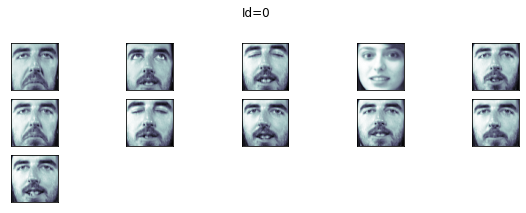

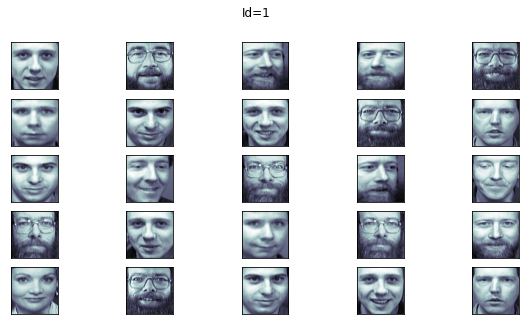

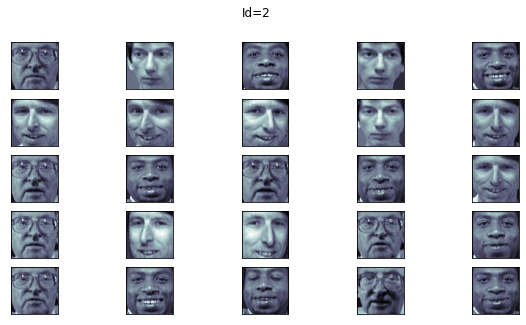

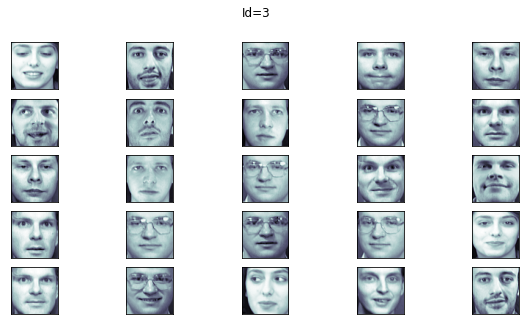

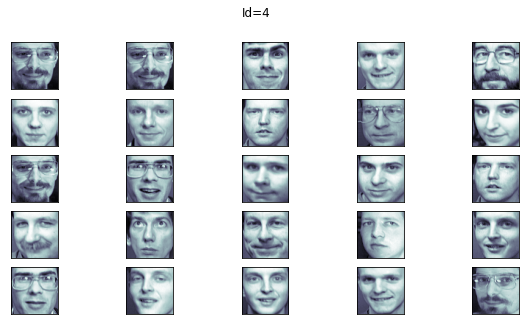

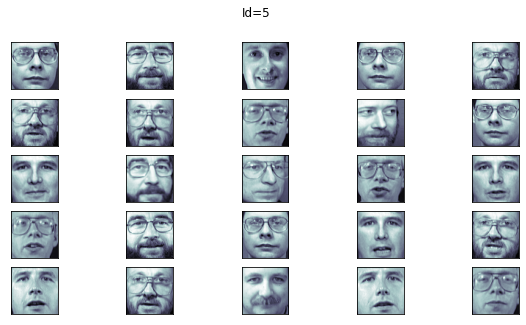

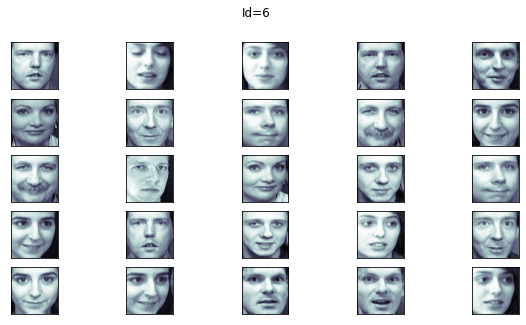

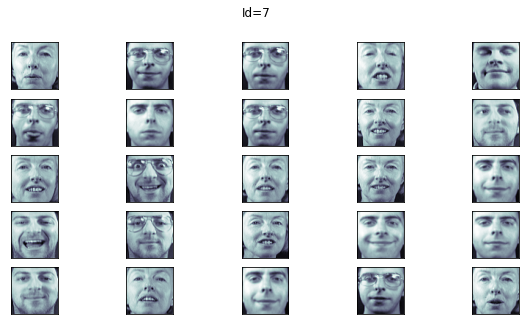

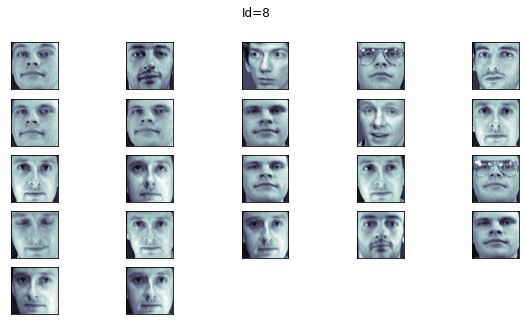

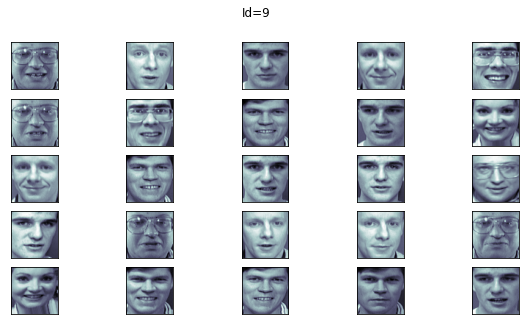

In [33]:
for labelID in range(n_clusters):
    # find all indexes into the `data` array that belong to the
    # current label ID, then randomly sample a maximum of 25 indexes
    # from the set
    idxs = np.where(clusters == labelID)[0]
    idxs = np.random.choice(idxs, size=min(25, len(idxs)),
        replace=False)

    # Extract the sampled indexes
    id_face = faces.images[idxs]

    #Plots sampled faces
    fig = plt.figure(figsize=(10,5))
    for i in range(min(25,len(idxs))):
        ax = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(id_face[i],
                  cmap=plt.cm.bone)
    fig.suptitle(f"Id={labelID}")
    

While the algorithm isn't perfect, we can see that K-means with PCA is picking up on some facial similarity or similar expressions. 

# (100 pts) Todo: Use new methods to classify heart disease

To compare how these new models perform with the other models discussed in the course, we will apply these new models on the heart disease dataset that was used in project 2.

## Background: The Dataset (Recap)

For this exercise we will be using a subset of the UCI Heart Disease dataset, leveraging the fourteen most commonly used attributes. All identifying information about the patient has been scrubbed. You will be asked to classify whether a <b>patient is suffering from heart disease</b> based on a host of potential medical factors.

The dataset includes 14 columns. The information provided by each column is as follows:
<ul>
    <li><b>age:</b> Age in years</li>
    <li><b>sex:</b> (1 = male; 0 = female)</li>
    <li><b>cp:</b> Chest pain type (0 = asymptomatic; 1 = atypical angina; 2 = non-anginal pain; 3 = typical angina)</li>
    <li><b>trestbps:</b> Resting blood pressure (in mm Hg on admission to the hospital)</li>
    <li><b>chol:</b> cholesterol in mg/dl</li>
    <li><b>fbs</b> Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)</li>
    <li><b>restecg:</b> Resting electrocardiographic results (0= showing probable or definite left ventricular hypertrophy by Estes' criteria; 1 = normal; 2 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV))</li>
    <li><b>thalach:</b> Maximum heart rate achieved</li>
    <li><b>exang:</b> Exercise induced angina (1 = yes; 0 = no)</li>
    <li><b>oldpeak:</b> Depression induced by exercise relative to rest</li>
    <li><b>slope:</b> The slope of the peak exercise ST segment (0 = downsloping; 1 = flat; 2 = upsloping)</li>
    <li><b>ca:</b> Number of major vessels (0-3) colored by flourosopy</li>
    <li><b>thal:</b> 1 = normal; 2 = fixed defect; 7 = reversable defect</li>
    <li><b><u>sick:</u></b> Indicates the presence of Heart disease (True = Disease; False = No disease)</li>
</ul>
    

## Preprocess Data

This part is done for you since you would have already completed it in project 2. Use the train, target, test, and target_test for all future parts. We also provide the column names for each transformed column for future use.

In [34]:
#Preprocess Data

#Load Data
data = pd.read_csv('datasets/heartdisease.csv')

#Transform target feature into numerical
le = LabelEncoder() 
data['target'] = le.fit_transform(data['sick'])
data = data.drop(["sick"], axis =1)

#Split target and data
y = data["target"]
x = data.drop(["target"],axis = 1)

#Train test split
#40% in test data as was in project 2
train_raw, test_raw, target, target_test = train_test_split(x,y, test_size=0.4, stratify= y, 
                                                            random_state=0)

#Feature Transformation
#This is the only change from project 2 since we replaced standard scaler to minmax
#This was done to ensure that the numerical features were still of the same scale
#as the one hot encoded features
num_pipeline = Pipeline([
    ('minmax', MinMaxScaler()) 
])

heart_num = train_raw.drop(['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca','thal'], 
                           axis=1)
numerical_features = list(heart_num)
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca','thal']

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, numerical_features),
    ("cat", OneHotEncoder(categories='auto'), categorical_features),
])

#Transform raw data 
train = full_pipeline.fit_transform(train_raw)
test = full_pipeline.transform(test_raw) #Note that there is no fit calls

#Extracts features names for each transformed column
feature_names = full_pipeline.get_feature_names_out(list(x.columns))


In [35]:
print("Column names after transformation by pipeline: ", feature_names)


Column names after transformation by pipeline:  ['num__age' 'num__trestbps' 'num__chol' 'num__thalach' 'num__oldpeak'
 'cat__sex_0' 'cat__sex_1' 'cat__cp_0' 'cat__cp_1' 'cat__cp_2' 'cat__cp_3'
 'cat__fbs_0' 'cat__fbs_1' 'cat__restecg_0' 'cat__restecg_1'
 'cat__restecg_2' 'cat__exang_0' 'cat__exang_1' 'cat__slope_0'
 'cat__slope_1' 'cat__slope_2' 'cat__ca_0' 'cat__ca_1' 'cat__ca_2'
 'cat__ca_3' 'cat__ca_4' 'cat__thal_0' 'cat__thal_1' 'cat__thal_2'
 'cat__thal_3']


The following shows the baseline accuracy of simply classifying every sample as the majority class.

In [36]:
#Baseline accuracy of using the majority class 
ct = target_test.value_counts()
print("Counts of each class in target_test: ")
print(ct)
print("Baseline Accuraccy of using Majority Class: ", np.max(ct)/np.sum(ct))


Counts of each class in target_test: 
0    66
1    56
Name: target, dtype: int64
Baseline Accuraccy of using Majority Class:  0.5409836065573771


## (25 pts) Decision Trees

### [5 pts] Apply  Decision Tree on Train Data

Apply the decision tree on the **train data** with default parameters of the DecisionTreeClassifier. **Report the accuracy and print the confusion matrix**. Make sure to use random_state = 0 so that your results match ours.

In [37]:
# decision tree classifier
clf_DT = DecisionTreeClassifier(random_state = 0)
clf_DT.fit(train, target)
predicted_DT = clf_DT.predict(test)


Accuracy:    0.696721
Precision:   0.711111
Recall:      0.571429
F1 Score:    0.633663


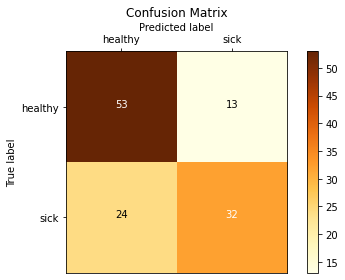

In [38]:
# confusion matrix
print("%-12s %f" % ('Accuracy: ', metrics.accuracy_score(target_test, predicted_DT)))
print("%-12s %f" % ('Precision:', metrics.precision_score(target_test, predicted_DT)))
print("%-12s %f" % ('Recall:', metrics.recall_score(target_test, predicted_DT)))
print("%-12s %f" % ('F1 Score:', metrics.f1_score(target_test, predicted_DT)))
draw_confusion_matrix(target_test, predicted_DT, ['healthy', 'sick'])


The accuracy is 69.6721%, meaning it overall predicts the correct label 69.6721% of the time. The precision is higher, meaning that we can trust this model more for healthy predictions, the recall is lower, meaning that given it sometimes labels healthy values as sick.

### [5 pts] Visualize the Decision Tree

Visualize the first two layers of the decision tree that you trained.

[Text(0.5, 0.8333333333333334, 'cat__cp_0 <= 0.5\ngini = 0.496\nsamples = 100.0%\nvalue = [0.547, 0.453]'),
 Text(0.25, 0.5, 'num__chol <= 0.223\ngini = 0.283\nsamples = 48.6%\nvalue = [0.83, 0.17]'),
 Text(0.125, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.375, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.75, 0.5, 'cat__ca_0 <= 0.5\ngini = 0.403\nsamples = 51.4%\nvalue = [0.28, 0.72]'),
 Text(0.625, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.875, 0.16666666666666666, '\n  (...)  \n')]

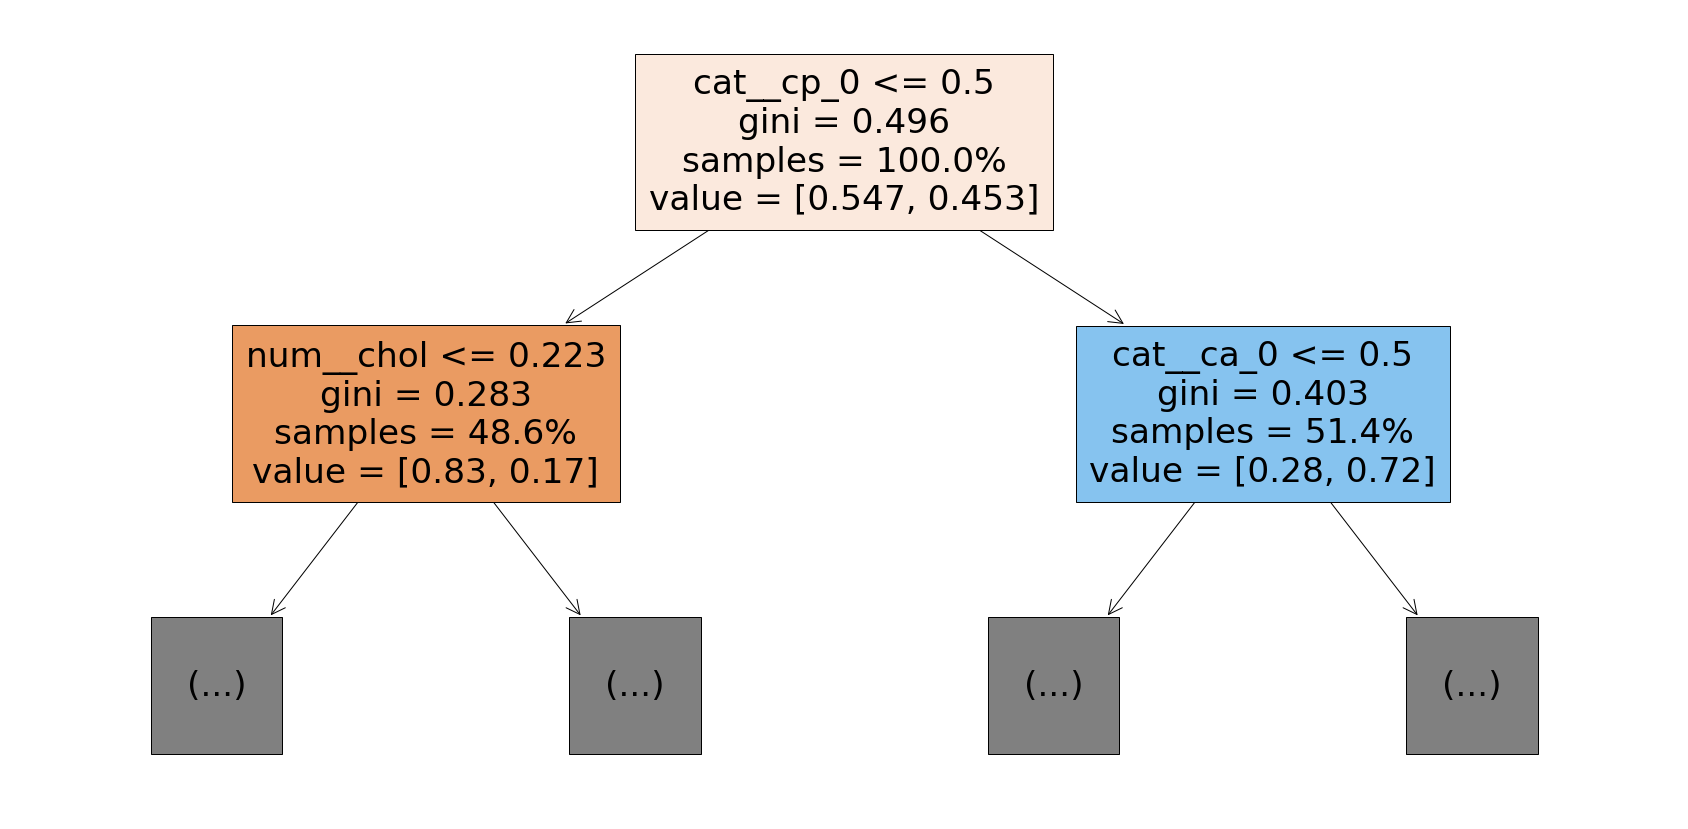

In [39]:
plt.figure(figsize = (30, 15))
tree.plot_tree(clf_DT, max_depth = 1, proportion = True, feature_names = feature_names,
               filled = True)


**What is the gini index improvement of the first split?**

Response:

The gini index improvement for the first split is $0.496 - (0.514 \cdot 0.403) - (0.486 \cdot 0.283) = 0.15132$


### [5 pts] Plot the importance of each feature for the Decision Tree

<AxesSubplot:>

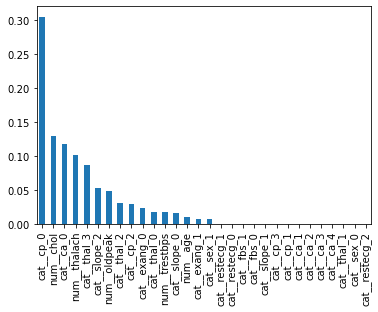

In [40]:
imp_pd_DT = pd.Series(data = clf_DT.feature_importances_, index = feature_names)
imp_pd_DT = imp_pd_DT.sort_values(ascending = False)
imp_pd_DT.plot.bar()


**How many features have non-zero importance for the Decision Tree? If we remove the features with zero importance, will it change the decision tree for the same sampled dataset?** 

In [41]:
data.columns


Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

Response: 

16 features have non-zero importance for the Decision Tree. If we remove the features with 0 importance, it will **NOT** change the decision tree for the same sampled dataset as these features provide no information to the decision tree, so it would never split on this feature. Thus, removing this feature that provides little to no information gain would not change the decision tree because in both situations, it will not query on that feature.  

### [10 pts] Optimize Decision Tree

While the default Decision Tree performs fairly well on the data, lets see if we can improve performance by optimizing the parameters.

Run a GridSearchCV with 3-Fold Cross Validation for the Decision Tree. Find the best model parameters amongst the following:

- max_depth = [1,2,3,4,5,10,15]
- min_samples_split = [2,4,6,8]
- criterion = ["gini", "entropy"]

After using GridSearchCV, print the best model parameters and the best score.

In [42]:
# Define the parameter grid
param_grid = {
    'max_depth': [1, 2, 3, 4, 5, 10, 15],
    'min_samples_split': [2, 4, 6, 8],
    'criterion': ["gini", "entropy"]
}

# Create the Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state = 0)

k = 3
kf = KFold(n_splits = k, random_state = None)
# you did not do the Kfold before 

# Perform GridSearchCV
grid_search = GridSearchCV(
    dt_classifier,
    param_grid,
    cv= kf,  # 3-fold cross-validation
    scoring='accuracy'  # evaluation metric
)

# Fit the data to find the best parameters
grid_search.fit(train, target)

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)


Best Parameters:  {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 8}
Best Score:  0.7681238615664846


**Using the best model you have, report the test accuracy and print out the confusion matrix**

In [43]:
dt_best_classifier = DecisionTreeClassifier(criterion = 'entropy', max_depth = 4,
                                            min_samples_split = 8, random_state = 0)
dt_best_classifier.fit(train, target)


DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_split=8,
                       random_state=0)

In [44]:
predicted_best_classifer = dt_best_classifier.predict(test)


Accuracy:    0.737705
Precision:   0.642857
Recall:      0.750000
F1 Score:    0.692308


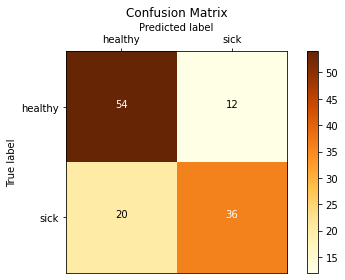

In [45]:
print("%-12s %f" % ('Accuracy: ', metrics.accuracy_score(predicted_best_classifer, 
                                                         target_test)))
print("%-12s %f" % ('Precision:', metrics.precision_score(predicted_best_classifer, 
                                                          target_test)))
print("%-12s %f" % ('Recall:', metrics.recall_score(predicted_best_classifer, 
                                                    target_test)))
print("%-12s %f" % ('F1 Score:', metrics.f1_score(predicted_best_classifer, target_test)))
draw_confusion_matrix(target_test, predicted_best_classifer, ['healthy', 'sick'])


The accuracy is 73.7705%, but the precision score is lower at 64.2857%, indicating that there are higher chances where the model may predict more healthy values that are actually sick. The recall value is higher and indicates a better predictor of true healthy values among all healthy values. 

## (20 pts) Multi-Layer Perceptron

### [5 pts] Applying a Multi-Layer Perceptron
Apply the MLP on the **train data** with hidden_layer_sizes=(100,100) and max_iter = 800. **Report the accuracy and print the confusion matrix**. Make sure to set random_state=0. 

In [46]:
clf_MLP = MLPClassifier(hidden_layer_sizes = (100, 100), max_iter = 800, random_state = 0)
clf_MLP.fit(train, target)
predicted_MLP = clf_MLP.predict(test)


Accuracy:    0.819672
Precision:   0.660714
Recall:      0.925000
F1 Score:    0.770833


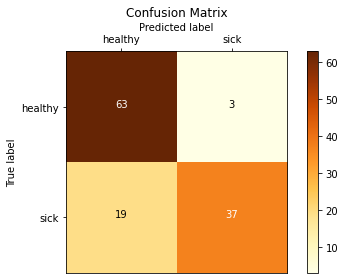

In [47]:
print("%-12s %f" % ('Accuracy: ', metrics.accuracy_score(predicted_MLP, target_test)))
print("%-12s %f" % ('Precision:', metrics.precision_score(predicted_MLP, target_test)))
print("%-12s %f" % ('Recall:', metrics.recall_score(predicted_MLP, target_test)))
print("%-12s %f" % ('F1 Score:', metrics.f1_score(predicted_MLP, target_test)))
draw_confusion_matrix(target_test, predicted_MLP, ['healthy', 'sick'])


This model reports an overall high accuracy and recall score, indicating that it can accurately predict actual healthy values among all values it predicted. The precision is a bit smaller so it may give some healthy values that are actually sick. 

### [10 pts] Speedtest between Decision Tree and MLP

Let us compare the training times and prediction times of a Decision Tree and an MLP. **Time how long it takes for a Decision Tree and an MLP to perform a .fit operation (i.e. training the model). Then, time how long it takes for a Decision Tree and an MLP to perform a .predict operation (i.e. predicting the testing data). Print out the timings and specify which model was quicker for each operation.** We recommend using the [time](https://docs.python.org/3/library/time.html) python module to time your code. 
An example of the time module was shown in project 2. Use the default Decision Tree Classifier and the MLP with the previously mentioned parameters.

In [48]:
import time


In [49]:
default_MLP = MLPClassifier(hidden_layer_sizes=(100,100), max_iter = 800, random_state = 0)
t0 = time.time()
default_MLP.fit(train, target)
t1 = time.time()
print("Multi-Layer Percepton Training Time : ", t1-t0)
default_DT = DecisionTreeClassifier(random_state = 0)
t0 = time.time()
default_DT.fit(train, target)
t1 = time.time()
print("Decision Tree Training Time : ", t1-t0)


Multi-Layer Percepton Training Time :  2.436753988265991
Decision Tree Training Time :  0.004244089126586914


The Multi-Layer Perception training time overall takes longer while the Decision Tree training time is a lot shorter and faster. 

In [50]:
t0 = time.time()
default_MLP.predict(test)
t1 = time.time()
print("Multi-Layer Prediction Time : ", t1-t0)
t0 = time.time()
default_DT.predict(test)
t1 = time.time()
print("Decision Tree Prediction Time : ", t1-t0)


Multi-Layer Prediction Time :  0.009195089340209961
Decision Tree Prediction Time :  0.0019338130950927734


The Multi-Later Preception testing time overall takes longer while the Decision Tree training time is a bit shorter and faster. 

Overall, the decision tree is a faster model to train and test. 

### [5 pts] Compare and contrast Decision Trees and MLPs.

**Describe at least one advantage and disadvantage of using an MLP over a Decision Tree.**

Response:

MLP's advantage over a decision tree is that it is more accurate, it's able to achieve a higher score of accuracy, precision, and recall, indicating that we can trust the MLP model more. However, the disadvantage of using MLP is that it takes longer to predict the data, and even more to train the data over the decision tree.

Other advantages of MLP are that it manages to captures complex and non-linear relationships in data and can be used in higher-dimensionality data but it can be hard to understand and interpret or to even understand how it came to it's conclusions on predictions, which is a disadvantage of the MLP and may be why a decision tree is better, for easier interpretability.


## (35 pts) PCA

### [5 pts] Transform the train data using PCA

Train a PCA model to project the train data on the top 10 components. **Print out the 10 principal components**. Look at the documentation of [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) for reference.

In [51]:
pca = PCA(n_components = 10)
#pca_pipe = Pipeline([('scalar', StandardScaler()), ('pca', pca)])
pca.fit(train)


PCA(n_components=10)

In [52]:
for i in range(10):
    print("component ", i + 1, ": ", pca.components_[i])
    

component  1 :  [ 0.06099466  0.04034864  0.01924581 -0.1017322   0.11071541 -0.12331434
  0.12331434  0.34265332 -0.13458918 -0.20936122  0.00129708 -0.01288493
  0.01288493  0.19693729 -0.19855631  0.00161902 -0.35054419  0.35054419
  0.04595587  0.29412324 -0.34007911 -0.20553518  0.07463263  0.08348053
  0.06758334 -0.02016132 -0.00039038  0.04438528 -0.31408112  0.27008622]
component  2 :  [ 0.05231789  0.02890251  0.03826504 -0.00733246 -0.0037285   0.44442215
 -0.44442215  0.07362246 -0.03171478 -0.02860787 -0.01329982 -0.02106535
  0.02106535  0.42589374 -0.44447634  0.0185826   0.0184908  -0.0184908
 -0.02183111  0.1435457  -0.1217146   0.02011775 -0.03199655  0.03699266
  0.00382438 -0.02893824  0.00336806  0.00301279  0.29007107 -0.29645192]
component  3 :  [-0.0427616  -0.03742143  0.00354063 -0.04733566  0.01801283  0.30699875
 -0.30699875  0.09347247  0.0329172  -0.0989118  -0.02747786  0.19990151
 -0.19990151 -0.43118048  0.40996579  0.0212147  -0.13223456  0.13223456
 -

### [5 pts] Percentage of variance explained by top 10 principal components

Using PCA's "explained_variance_ratio_", print the percentage of variance explained by the top 10 principal components.

In [53]:
pca_explained_variance_ratio = pca.explained_variance_ratio_
print(pca_explained_variance_ratio.sum())


0.877166378286218


The percentage of variance explained by the top 10 principal components is 87.716%.

### [5 pts] Transform the train and test data into train_pca and test_pca using PCA

Note: Use fit_transform for train and transform for test

In [54]:
train_pca = pca.fit_transform(train)
test_pca = pca.transform(test)


### [5 pts] PCA+Decision Tree

Train the default Decision Tree Classifier using train_pca. **Report the accuracy using test_pca and print the confusion matrix**.

In [55]:
clf_PCA_DT = DecisionTreeClassifier(random_state = 0)
clf_PCA_DT.fit(train_pca, target)
predicated_PCA_DT = clf_PCA_DT.predict(test_pca)


Accuracy:    0.762295
Precision:   0.714286
Recall:      0.754717
F1 Score:    0.733945


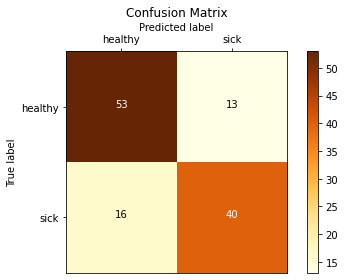

In [56]:
print("%-12s %f" % ('Accuracy: ', metrics.accuracy_score(predicated_PCA_DT, target_test)))
print("%-12s %f" % ('Precision:', metrics.precision_score(predicated_PCA_DT, target_test)))
print("%-12s %f" % ('Recall:', metrics.recall_score(predicated_PCA_DT, target_test)))
print("%-12s %f" % ('F1 Score:', metrics.f1_score(predicated_PCA_DT, target_test)))
draw_confusion_matrix(target_test, predicated_PCA_DT, ['healthy', 'sick'])


**Does the model perform better with or without PCA?**

Response:

The model performs better as it obtains an overall higher accuracy, precision, recall, and F1 score. A reason as to why PCA obtained better results is because PCA projects data onto a linear subspace that preserves the most variance, reducing the number of dimensionality in the data, essentially choosing which features are the most importance in explaining the variance in the data. This helps with overfitting and easier implementation, but reducing the number of dimensions can lead to loss in information, but isnce our model improved, we can safely say the tradeoff and risks were well accounted for. 


### [5 pts] PCA+MLP

Train the MLP classifier with the same parameters as before using train_pca. **Report the accuracy using test_pca and print the confusion matrix**.

In [57]:
clf_PCA_MLP = MLPClassifier(hidden_layer_sizes = (100, 100), max_iter = 800, random_state = 0)
clf_PCA_MLP.fit(train_pca, target)
predicted_PCA_MLP = clf_PCA_MLP.predict(test_pca)


Accuracy:    0.778689
Precision:   0.625000
Recall:      0.853659
F1 Score:    0.721649


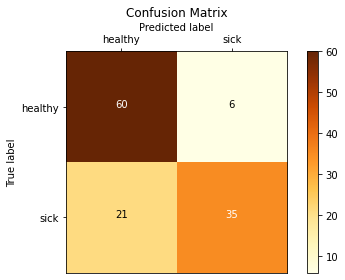

In [58]:
print("%-12s %f" % ('Accuracy: ', metrics.accuracy_score(predicted_PCA_MLP, target_test)))
print("%-12s %f" % ('Precision:', metrics.precision_score(predicted_PCA_MLP, target_test)))
print("%-12s %f" % ('Recall:', metrics.recall_score(predicted_PCA_MLP, target_test)))
print("%-12s %f" % ('F1 Score:', metrics.f1_score(predicted_PCA_MLP, target_test)))
draw_confusion_matrix(target_test, predicted_PCA_MLP, ['healthy', 'sick'])


**Does the model perform better with or without PCA?**

Response:

The model performs worse as it obtains an lower higher accuracy, precision, recall, and F1 score. A reason as to why PCA obtained worse results is because PCA projects data onto a linear subspace, reducing dimensionality and therefore losing information of data. PCA also does not work too well with non-linear data, in which MLP does. 


### [10 pts] Pros and Cons of PCA

**In your own words, provide at least two pros and at least two cons for using PCA**

Response:

pros:
- reduce dimensionality, allows you to map to higher dimension by transforming the data in higher dimesnions into a linear subspace
- helps with overfitting by reducing dimensionality, since this is reducing the complexity of the model

cons:
- not good for non-linear data, so classification issues that do not follow a trend may be an issue
- can result in loss of information due to the reduction in dimensionality

## (20 pts) K-Means Clustering

### [5 pts] Apply K-means to the train data and print out the Inertia score

Use n_cluster = 5 and random_state = 0.

In [59]:
clf_kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 0)
clf_kmeans.fit(train)

# decision default

KMeans(n_clusters=5, random_state=0)

In [60]:
# inertia.append(clf_kmeans.inertia_)
print("Inertia score is: ", clf_kmeans.inertia_)
# print(f"Inertia for K = {k}: {kmeans.inertia_}")


Inertia score is:  491.0665663612592


### [10 pts] Find the optimal cluster size using the elbow method. 

Use the elbow method to find the best cluster size or range of best cluster sizes for the train data. Check the cluster sizes from 2 to 20. Make sure to plot the Inertia and state where you think the elbow starts. Make sure to use random_state = 0.

In [61]:
cluster_size = list(range(2, 21))
inertia_elbow = []
for k in cluster_size:
    clf_kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state = 0)
    clf_kmeans.fit(train)
    inertia_elbow.append(clf_kmeans.inertia_)
    print(f"Inertia for K = {k}: {clf_kmeans.inertia_}")


Inertia for K = 2: 619.2596852490838
Inertia for K = 3: 562.2941749488492
Inertia for K = 4: 515.3501104402981
Inertia for K = 5: 491.0665663612592
Inertia for K = 6: 458.34490628572456
Inertia for K = 7: 436.46731311592123
Inertia for K = 8: 427.6424313245354
Inertia for K = 9: 409.34538543076576
Inertia for K = 10: 393.8362013824141
Inertia for K = 11: 375.62714291417694
Inertia for K = 12: 366.87257419180406
Inertia for K = 13: 356.07044286127075
Inertia for K = 14: 353.0506627827144
Inertia for K = 15: 342.9664892654279
Inertia for K = 16: 335.8288846772815
Inertia for K = 17: 325.33654094415067
Inertia for K = 18: 310.3448076066396
Inertia for K = 19: 306.7095752890682
Inertia for K = 20: 295.928862919753


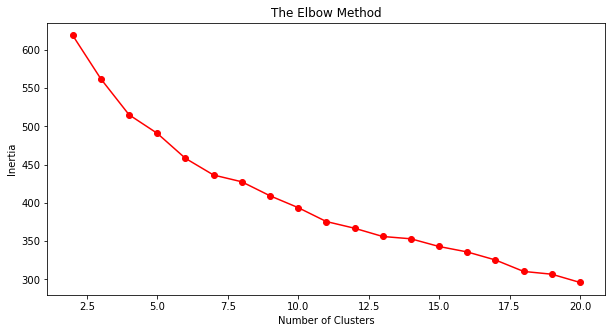

In [62]:
plt.figure(figsize = (10, 5))
plt.plot(cluster_size, inertia_elbow, marker = 'o', color = 'red')
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


The elbow is not clearly defined, but the slowdown is around 7, so I think the optimal number of clusters is 7. 

### [5 pts] Find the optimal cluster size for the train_pca data
 
Repeat the same experiment but use train_pca instead of train. 

In [63]:
cluster_sizePCA = list(range(2, 21))
inertia_elbowPCA = []
for k in cluster_sizePCA:
    clf_kmeansPCA = KMeans(n_clusters = k, init = 'k-means++', random_state = 0)
    clf_kmeansPCA.fit(train_pca)
    inertia_elbowPCA.append(clf_kmeansPCA.inertia_)
    print(f"Inertia for K = {k}: {clf_kmeansPCA.inertia_}")
    

Inertia for K = 2: 526.8986473659891
Inertia for K = 3: 469.4865632663006
Inertia for K = 4: 423.216113520396
Inertia for K = 5: 403.5879123750668
Inertia for K = 6: 371.07845721489093
Inertia for K = 7: 350.3642628743974
Inertia for K = 8: 330.04761506297496
Inertia for K = 9: 314.6918920164621
Inertia for K = 10: 298.7447439936633
Inertia for K = 11: 288.504429480324
Inertia for K = 12: 277.35479695139935
Inertia for K = 13: 266.20679282269015
Inertia for K = 14: 258.12394695638193
Inertia for K = 15: 250.34211491204894
Inertia for K = 16: 234.46445989492148
Inertia for K = 17: 231.17570259556643
Inertia for K = 18: 221.78373427947014
Inertia for K = 19: 220.04830474526761
Inertia for K = 20: 211.59508812745736


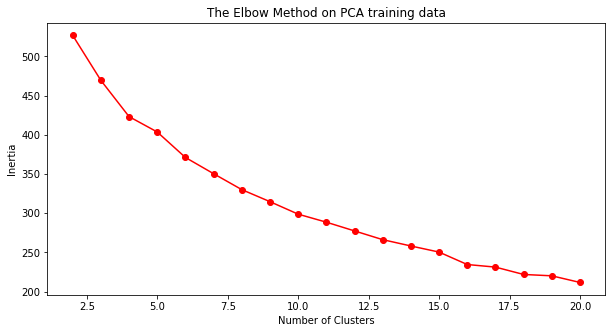

In [64]:
plt.figure(figsize = (10, 5))
plt.plot(cluster_sizePCA, inertia_elbowPCA, marker = 'o', color = 'red')
plt.title('The Elbow Method on PCA training data')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


**Notice that the inertia is much smaller for every cluster size when using PCA features. Why do you think this is happening? Hint: Think about what Inertia is calculating and consider the number of features that PCA outputs.**

Response:

Inertia is how well the data is clustered by k-means measured by the distance between the data point and cluster size. The closer the data is to the cluster, the smaller the inertia score will be and therefore the better classification. The trade-off between inertia and K-means is that as k increases, the inertia decreases due to the fact that it takes in more neighbors so it inches closer to the cluster. We also know that the PCA reduces the dimensionality, and by reducing the number of dimensions, we also reduce the number of squared features to consider in the equation for inertia. The formula involves calcuating the squared distance of each data point to the center of the cluster, so by removing the dimensions, you reduce the number of data points to consider. 

# (100 pts) Putting it all together

Through all the homeworks and projects, you have learned how to apply many different models to perform a supervised learning task. We are now asking you to take everything that you learned to create a model that can predict whether a hotel reservation will be canceled or not.


**Context**

Hotels see millions of people every year and always wants to keep rooms occupied and payed for. Cancellations make the business lose money since it may make it difficult to reserve to another customer on such short notice. As such, it is useful for a hotel to know whether a reservation is likely to cancel or not. The following dataset will provide a variety of information about a booking that you will use to predict whether that booking will cancel or not. 


Property Management System - PMS

**Attribute Information**

(C) is for Categorical 

(N) is for Numeric

    1) is_canceled (C) : Value indicating if the booking was canceled (1) or not (0).
    2) hotel (C) : The datasets contains the booking information of two hotel. One of the hotels is a resort hotel and the other is a city hotel.
    3) arrival_date_month (C): Month of arrival date with 12 categories: “January” to “December”
    4) stays_in_weekend_nights (N): Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
    5) stays_in_week_nights (N): Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel BO and BL/Calculated by counting the number of week nights
    6) adults (N): Number of adults
    7) children (N): Number of children
    8) babies (N): Number of babies
    9) meal (C): Type of meal
    10) country (C): Country of origin.
    11) previous_cancellations (N): Number of previous bookings that were canceled by the customer prior to the current booking
    12) previous_bookings_not_canceled (N) : Number of previous bookings not canceled by the customer prior to the current booking
    13) reserved_room_type (C): Code of room type reserved. Code is presented instead of designation for anonymity reasons
    14) booking_changes (N) : Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation
    15) deposit_type (C) : No Deposit – no deposit was made; Non Refund – a deposit was made in the value of the total stay cost; Refundable – a deposit was made with a value under the total cost of stay
    16) days_in_waiting_list (N): Number of days the booking was in the waiting list before it was confirmed to the customer
    17) customer_type (C): Group – when the booking is associated to a group; Transient – when the booking is not part of a group or contract, and is not associated to other transient booking; Transient-party – when the booking is transient, but is associated to at least other transient booking
    18) adr (N): Average Daily Rate (Calculated by dividing the sum of all lodging transactions by the total number of staying nights)
    19) required_car_parking_spaces (N): Number of car parking spaces required by the customer
    20) total_of_special_requests (N): Number of special requests made by the customer (e.g. twin bed or high floor)
    21) name (C): Name of the Guest (Not Real)
    22) email (C): Email (Not Real)
    23) phone-number (C): Phone number (not real)

This dataset is quite large with 86989 samples. This makes it difficult to just brute force running a lot of models. As such, you have to be thoughtful when designing your models.

The file name for the training data is "hotel_booking.csv".

**Challenge**

This project is about being able to predict whether a reservation is likely to cancel based on the
input parameters available to us. We will ask you to perform some specific instructions to lead you in the right direction but you are given free reign on which models to use and the preprocessing steps you make. We will ask you to **write out a description of what models you choose and why you choose them**.

## (50 pts) Preprocessing


**Preprocessing:**
For the dataset, the following are mandatory pre-processing steps for your data:

- Use One-Hot Encoding on all categorical features (specify whether you keep the extra feature or not for features with multiple values)
- Determine which fields need to be dropped
- Handle missing values (Specify your strategy)
- Rescale the real valued features using any strategy you choose (StandardScaler, MinMaxScaler, Normalizer, etc)
- Augment at least one feature
- Implement a train-test split with 20% of the data going to the test data. Make sure that the test and train data are balanced in terms of the desired class.


After writing your preprocessing code, write out a description of what you did for each step and provide a justification for your choices. All descriptions should be written in the markdown cells of the jupyter notebook. Make sure your writing is clear and professional.  

We highly recommend reading through the [scikit-learn documentation](https://scikit-learn.org/stable/data_transforms.html) to make this part easier.

In [65]:
hotels = pd.read_csv('/Users/aaron/EC_ENGR_M148/week8/Project 3/datasets/hotel_booking.csv')


In [66]:
hotels.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78290 entries, 0 to 78289
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     78290 non-null  int64  
 1   hotel                           78290 non-null  object 
 2   lead_time                       78290 non-null  int64  
 3   arrival_date_month              78290 non-null  object 
 4   stays_in_weekend_nights         78290 non-null  int64  
 5   stays_in_week_nights            78290 non-null  int64  
 6   adults                          78290 non-null  int64  
 7   children                        78287 non-null  float64
 8   babies                          78290 non-null  int64  
 9   meal                            78290 non-null  object 
 10  country                         78290 non-null  object 
 11  previous_cancellations          78290 non-null  int64  
 12  previous_bookings_not_canceled  

We see that children is 3 values less than all other variables, so we have three missing values in that variable and would need to replace it. 

In [67]:
# examining missing values
empty_children = hotels.index[hotels['children'].isnull()]
empty_children


Int64Index([48048, 52055, 56232], dtype='int64')

We see that row 48048, 52055, and 56232 are where the missing values are


<AxesSubplot:xlabel='children', ylabel='Count'>

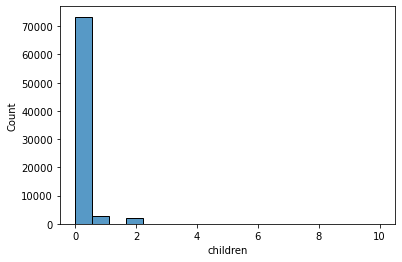

In [68]:
sns.histplot(hotels['children'])
# very finte values is categorical 


A large part of the distribution for children is 0, so we will use the mode data to replace the missing values. The distribution for children is mainly clustered to 0 as seen from the graph, so given three new values, it will most likely be 0 as well. But first, we can examine the nearest neighbours for the children in order to see what if there are any similarities in the data we should be aware of. 


In [69]:
hotels.iloc[48045:48054, :]


is_canceled         hotel  lead_time arrival_date_month  \
48045            0    City Hotel          1          September   
48046            1    City Hotel        334          September   
48047            0    City Hotel          2             August   
48048            1    City Hotel          1             August   
48049            0  Resort Hotel         24              April   
48050            0    City Hotel          8             August   
48051            1    City Hotel        169                May   
48052            1    City Hotel         41              March   
48053            0    City Hotel         38               June   

       stays_in_weekend_nights  stays_in_week_nights  adults  children  \
48045                        0                     2       1       0.0   
48046                        0                     2       2       0.0   
48047                        0                     1       2       0.0   
48048                        0                     2       3       NaN   
48049                        0                     4       2       0.0   
48050                        1                     1       2       1.0   
48051                        2                     1       2       0.0   
48052                        0                     4       1       0.0   
48053                        1                     0       2       2.0   

       babies meal  ... booking_changes  deposit_type  days_in_waiting_list  \
48045       0   BB  ...               0    No Deposit                     0   
48046       0   BB  ...               0    Non Refund                     0   
48047       0   HB  ...               0    No Deposit                     0   
48048       0   BB  ...               0    No Deposit                     0   
48049       0   BB  ...               0    No Deposit                     0   
48050       0   BB  ...               0    No Deposit                     0   
48051       0   BB  ...               0    No Deposit                     0   
48052       0   SC  ...               0    No Deposit                     0   
48053       0   BB  ...               0    No Deposit                     0   

         customer_type    adr required_car_parking_spaces  \
48045        Transient   67.0                           1   
48046  Transient-Party   62.0                           0   
48047  Transient-Party  166.0                           0   
48048  Transient-Party   18.0                           0   
48049        Transient   71.0                           1   
48050        Transient  159.5                           0   
48051        Transient  117.0                           0   
48052        Transient   83.3                           0   
48053        Transient  155.0                           0   

       total_of_special_requests               name  \
48045                          0      Kendra Thomas   
48046                          0  Julie Christensen   
48047                          0       Paul Johnson   
48048                          2       Frank Burton   
48049                          1      Nancy Woodard   
48050                          0       Alan Hoffman   
48051                          0     David Thompson   
48052                          0    Darrell Farrell   
48053                          0     Erin Wilkinson   

                            email  phone-number  
48045         KThomas@comcast.net  165-309-0686  
48046  Christensen.Julie@mail.com  840-900-0492  
48047       Paul_Johnson@zoho.com  162-187-4436  
48048    Frank.Burton@comcast.net  395-084-3601  
48049   Woodard_Nancy@hotmail.com  807-385-0095  
48050    Alan.Hoffman@hotmail.com  541-972-3802  
48051          DThompson@zoho.com  969-123-4348  
48052    Darrell_Farrell@zoho.com  962-379-6655  
48053         Erin.W61@yandex.com  756-671-4562  

[9 rows x 24 columns]

In [70]:
hotels.iloc[52050:52060, :]


is_canceled         hotel  lead_time arrival_date_month  \
52050            0    City Hotel         34           February   
52051            1  Resort Hotel         53           November   
52052            1    City Hotel        170             August   
52053            0  Resort Hotel        296          September   
52054            1    City Hotel         58               June   
52055            1    City Hotel          1             August   
52056            0  Resort Hotel         51             August   
52057            0    City Hotel        198            October   
52058            0    City Hotel        247               June   
52059            0  Resort Hotel          0                May   

       stays_in_weekend_nights  stays_in_week_nights  adults  children  \
52050                        1                     4       2       0.0   
52051                        3                     5       2       0.0   
52052                        0                     4       2       0.0   
52053                        4                     8       2       0.0   
52054                        1                     1       2       0.0   
52055                        0                     2       2       NaN   
52056                        2                     4       2       0.0   
52057                        1                     1       2       0.0   
52058                        1                     1       1       0.0   
52059                        0                     1       1       0.0   

       babies meal  ... booking_changes  deposit_type  days_in_waiting_list  \
52050       0   BB  ...               0    No Deposit                     0   
52051       0   HB  ...               1    No Deposit                     0   
52052       0   BB  ...               0    No Deposit                     0   
52053       0   BB  ...               0    No Deposit                     0   
52054       0   SC  ...               0    No Deposit                     0   
52055       0   BB  ...               0    No Deposit                     0   
52056       0   HB  ...               1    No Deposit                     0   
52057       0   BB  ...               0    No Deposit                     0   
52058       0   HB  ...               1    No Deposit                     0   
52059       0   BB  ...               0    No Deposit                     0   

         customer_type     adr required_car_parking_spaces  \
52050  Transient-Party   66.00                           0   
52051        Transient   65.23                           0   
52052        Transient  175.50                           0   
52053         Contract   48.75                           0   
52054        Transient  116.10                           0   
52055  Transient-Party   12.00                           0   
52056        Transient  183.00                           0   
52057  Transient-Party   60.00                           0   
52058  Transient-Party   90.00                           0   
52059        Transient   63.00                           0   

       total_of_special_requests                name  \
52050                          1        Deborah Hahn   
52051                          0           Sean Bray   
52052                          0       Marissa Roach   
52053                          1         Karen Potts   
52054                          0          Mary Hicks   
52055                          1        David Murphy   
52056                          1       Ryan Buchanan   
52057                          0       Matthew Black   
52058                          0       Nicole Willis   
52059                          0  Krystal Washington   

                                  email  phone-number  
52050           Deborah.Hahn58@mail.com  846-956-7747  
52051             Bray_Sean@hotmail.com  821-107-9281  
52052             Marissa_Roach@att.com  885-754-2427  
52053           Karen_Potts@comcast.net  755-748-3867  
52054          

In [71]:
hotels.iloc[56227:56237, :]


is_canceled         hotel  lead_time arrival_date_month  \
56227            0    City Hotel         17               June   
56228            0  Resort Hotel         90              April   
56229            1    City Hotel        148           December   
56230            1    City Hotel         21               July   
56231            0  Resort Hotel        186               June   
56232            1    City Hotel          2             August   
56233            1    City Hotel        161              March   
56234            0    City Hotel         56          September   
56235            0    City Hotel        414               July   
56236            0    City Hotel         42            October   

       stays_in_weekend_nights  stays_in_week_nights  adults  children  \
56227                        2                     1       2       0.0   
56228                        2                     5       2       0.0   
56229                        1                     3       2       0.0   
56230                        2                     2       2       0.0   
56231                        4                    10       1       0.0   
56232                        1                     0       2       NaN   
56233                        1                     2       2       0.0   
56234                        0                     2       2       0.0   
56235                        0                     2       1       0.0   
56236                        1                     1       2       0.0   

       babies meal  ... booking_changes  deposit_type  days_in_waiting_list  \
56227       0   SC  ...               0    No Deposit                     0   
56228       0   HB  ...               0    No Deposit                     0   
56229       0   BB  ...               0    Non Refund                    98   
56230       0   SC  ...               0    No Deposit                     0   
56231       0   HB  ...               0    No Deposit                     0   
56232       0   BB  ...               0    No Deposit                     0   
56233       0   HB  ...               0    Non Refund                   101   
56234       0   HB  ...               0    No Deposit                     0   
56235       0   HB  ...               1    No Deposit                     0   
56236       0   BB  ...               0    No Deposit                     0   

         customer_type     adr required_car_parking_spaces  \
56227        Transient  109.00                           0   
56228        Transient   62.05                           0   
56229        Transient   77.50                           0   
56230        Transient  130.00                           0   
56231        Transient   62.90                           0   
56232  Transient-Party   12.00                           0   
56233        Transient  130.00                           0   
56234  Transient-Party   82.00                           0   
56235  Transient-Party   95.50                           0   
56236        Transient  118.50                           0   

       total_of_special_requests               name  \
56227                          1    Jillian Acevedo   
56228                          0        Barry Terry   
56229                          0    Jackie Bradshaw   
56230                          0     Brittany Ortiz   
56231                          2       Daniel Lopez   
56232                          1       Craig Campos   
56233                          0       Julie Guzman   
56234                          0       Victor Kelly   
56235                          0  Matthew Mccormick   
56236                          1       Jerry Abbott   

                            email  phone-number  
56227      JillianAcevedo@att.com  581-475-8757  
56228  Barry_Terry@protonmail.com  306-942-2418  
56229        Jackie_B@xfinity.com  522-872-6969  
56230          BOrtiz@comcast.net  253-069-4821  
56231            Daniel_L@att.com  618-306-4601  
56232 

There doesn't seem to be anything glaring, so we continue to replace the missing values with 0. 

In [72]:
# setting up specific indices to be 0 
hotels.loc[empty_children, 'children'] = 0


In [73]:
# confirming that it is indeed replaced with 0 
hotels['children'][empty_children]


48048    0.0
52055    0.0
56232    0.0
Name: children, dtype: float64

In [74]:
hotels.columns


Index(['is_canceled', 'hotel', 'lead_time', 'arrival_date_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'country', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'booking_changes', 'deposit_type', 'days_in_waiting_list',
       'customer_type', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'name', 'email', 'phone-number'],
      dtype='object')

In [75]:
hotels.insert(4, 'total_stays', hotels['stays_in_weekend_nights'] + 
              hotels['stays_in_week_nights'])


I decided to augment a new feature called 'total_stays' in which is it is the total amount of overnight stays, calculated by adding both the stays in weekend nights and stays in week nights.


I now explore the different variables and see what the distribution of the variables are, what values they most commonly fall in between, and how discrete they are. 

In [76]:
hotels.max()


is_canceled                                               1
hotel                                          Resort Hotel
lead_time                                               737
arrival_date_month                                September
total_stays                                              57
stays_in_weekend_nights                                  16
stays_in_week_nights                                     41
adults                                                   55
children                                               10.0
babies                                                   10
meal                                              Undefined
country                                                 PRT
previous_cancellations                                   26
previous_bookings_not_canceled                           72
reserved_room_type                                        P
booking_changes                                          20
deposit_type                            

In [77]:
hotels.min()


is_canceled                                      0
hotel                                   City Hotel
lead_time                                        0
arrival_date_month                           April
total_stays                                      0
stays_in_weekend_nights                          0
stays_in_week_nights                             0
adults                                           0
children                                       0.0
babies                                           0
meal                                            BB
country                                        DEU
previous_cancellations                           0
previous_bookings_not_canceled                   0
reserved_room_type                               A
booking_changes                                  0
deposit_type                            No Deposit
days_in_waiting_list                             0
customer_type                             Contract
adr                            

array([[<AxesSubplot:title={'center':'is_canceled'}>,
        <AxesSubplot:title={'center':'lead_time'}>,
        <AxesSubplot:title={'center':'total_stays'}>,
        <AxesSubplot:title={'center':'stays_in_weekend_nights'}>],
       [<AxesSubplot:title={'center':'stays_in_week_nights'}>,
        <AxesSubplot:title={'center':'adults'}>,
        <AxesSubplot:title={'center':'children'}>,
        <AxesSubplot:title={'center':'babies'}>],
       [<AxesSubplot:title={'center':'previous_cancellations'}>,
        <AxesSubplot:title={'center':'previous_bookings_not_canceled'}>,
        <AxesSubplot:title={'center':'booking_changes'}>,
        <AxesSubplot:title={'center':'days_in_waiting_list'}>],
       [<AxesSubplot:title={'center':'adr'}>,
        <AxesSubplot:title={'center':'required_car_parking_spaces'}>,
        <AxesSubplot:title={'center':'total_of_special_requests'}>,
        <AxesSubplot:>]], dtype=object)

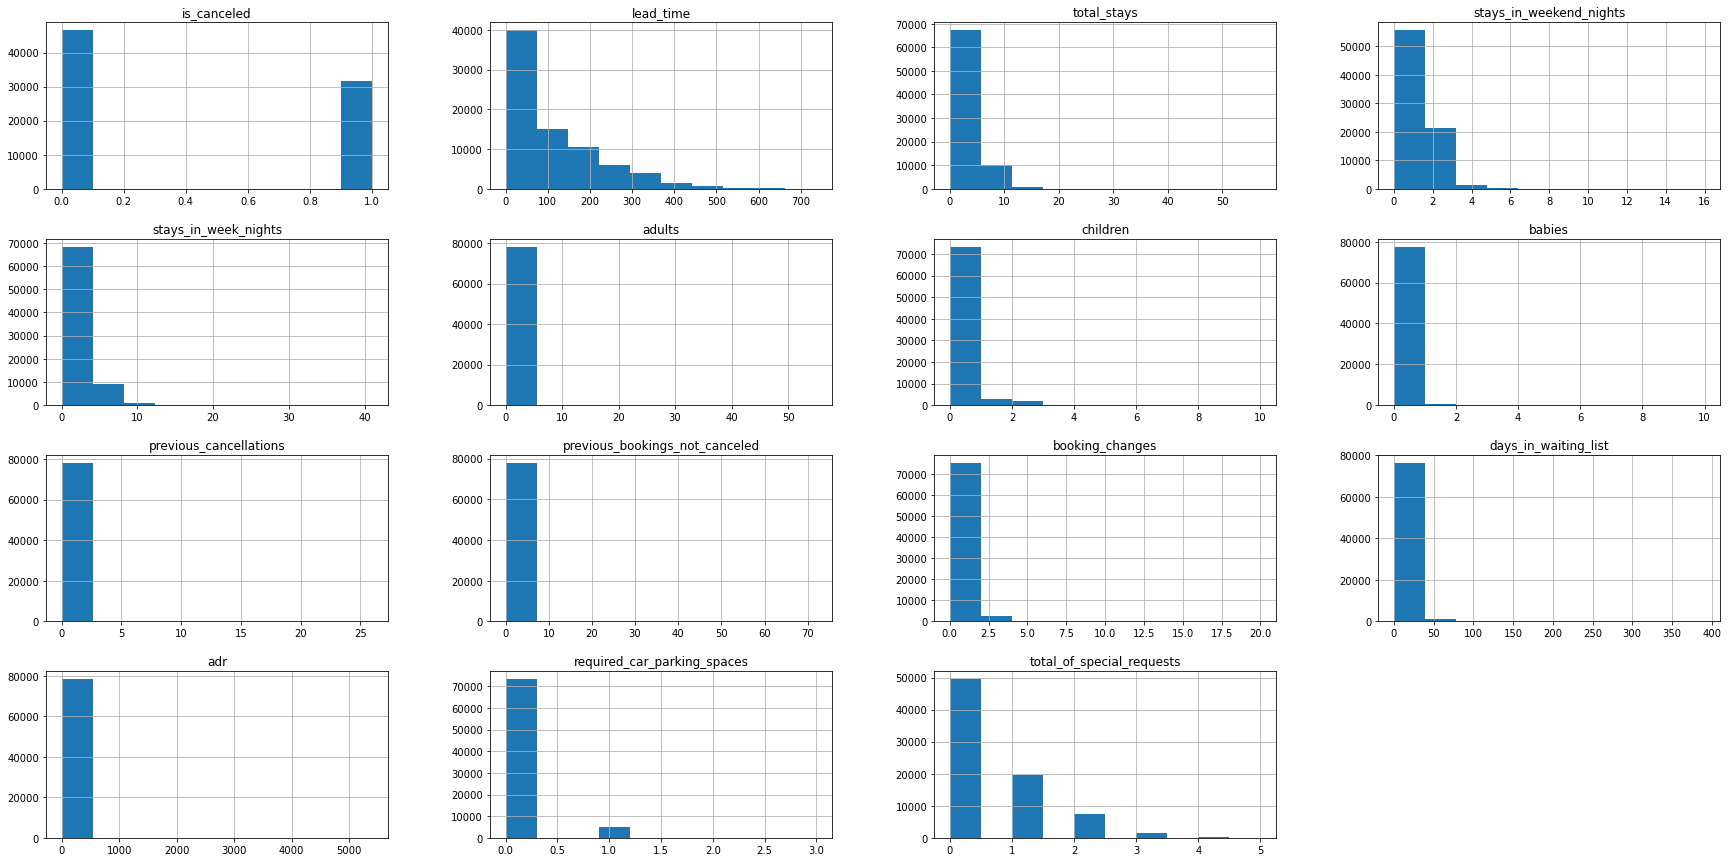

In [78]:
hotels.hist(figsize = (30, 15))


***is_canceled***, ***required_car_parking_spaces***, and ***total_of_special_requests*** are the only column that I think would require label encoding is_canceled is binary and the rest including is_canceled is discrete. 


0    46519
1    31771
Name: is_canceled, dtype: int64

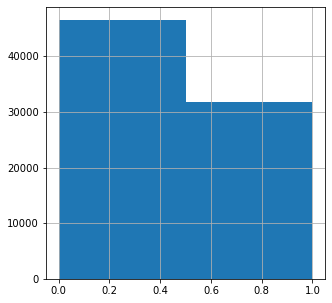

In [79]:
hotels['is_canceled'].hist(bins = 2, figsize = (5, 5))
hotels['is_canceled'].value_counts()


Examining the distribution of 'is_canceled', I believe they are pretty balanced as it does not fail the 1:4 ratio test.

In [80]:
le = LabelEncoder()

hotels['is_canceled'] = le.fit_transform(hotels['is_canceled'])

hotels['required_car_parking_spaces'] = le.fit_transform(
    hotels['required_car_parking_spaces'])

hotels['total_of_special_requests'] = le.fit_transform(hotels['total_of_special_requests'])


I also decided to drop 'name', 'email', and 'phone-number' as these are more like index values, provides way too many discrete values, and would highly likely provide no actual correlation in determining if a hotel booking is canceled. 

In [81]:
## setting up data
y_is_canceled = hotels['is_canceled']
x_hotels = hotels.drop(['is_canceled', 'name', 'email', 'phone-number'], axis = 1)


In [82]:
x_hotels.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78290 entries, 0 to 78289
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           78290 non-null  object 
 1   lead_time                       78290 non-null  int64  
 2   arrival_date_month              78290 non-null  object 
 3   total_stays                     78290 non-null  int64  
 4   stays_in_weekend_nights         78290 non-null  int64  
 5   stays_in_week_nights            78290 non-null  int64  
 6   adults                          78290 non-null  int64  
 7   children                        78290 non-null  float64
 8   babies                          78290 non-null  int64  
 9   meal                            78290 non-null  object 
 10  country                         78290 non-null  object 
 11  previous_cancellations          78290 non-null  int64  
 12  previous_bookings_not_canceled  

In [83]:
train_rawH, test_rawH, targetH, target_testH = train_test_split(x_hotels, y_is_canceled, 
                                                            test_size = 0.2, 
                                                            stratify = y_is_canceled, 
                                                            random_state=0)


In [84]:
train_rawH.shape

(62632, 21)

0    37215
1    25417
Name: is_canceled, dtype: int64

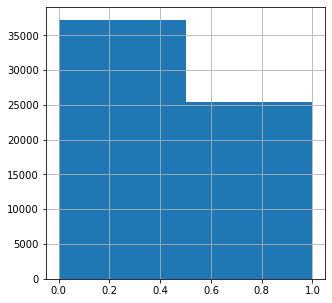

In [85]:
targetH.hist(bins = 2, figsize = (5, 5))
targetH.value_counts()


0    9304
1    6354
Name: is_canceled, dtype: int64

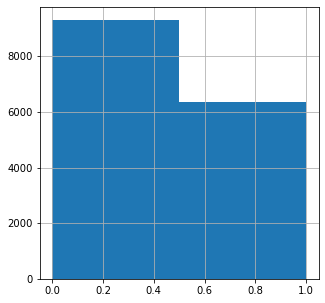

In [86]:
target_testH.hist(bins = 2, figsize = (5, 5))
target_testH.value_counts()


Examining the splitted data for target data for training and testing, both data is evenly splitted as it passes the 1:4 ratio test. 

In [87]:
num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# creates pipeline to standardize numeric values
'''
dataNum = ['lead_time', 'total_stays', 'stays_in_weekend_nights', 'stays_in_week_nights', 
           'adults', 'children', 'babies', 'previous_cancellations', 
           'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 
           'adr', 'required_car_parking_spaces', 'total_of_special_requests']
'''
dataNum = x_hotels.select_dtypes(include = 'number').columns

'''
dataCat = ['hotel', 'arrival_date_month', 'meal', 'country', 
           'reserved_room_type', 'deposit_type', 'customer_type']
'''

dataCat = x_hotels.select_dtypes(include = 'object').columns


# if there is a specific order, these ages have an order 
# if there is something finite and numeric (small unique values), it should be label encoded
    # binary can be label or one hot encoded 
# creates list of columns that are numeric vs categorical 
pipeLine = ColumnTransformer([
    ('num', num_pipeline, dataNum), # for numeric columns
    ('cat', OneHotEncoder(), dataCat) # for categorical columns
    ])


One-hot encoding for categorical features and scaling the numerical features using StandardScaler.

In [88]:
train_pipeH = pipeLine.fit_transform(train_rawH)
test_pipeH = pipeLine.transform(test_rawH)


In [89]:
train_pipeH.shape, test_pipeH.shape


((62632, 55), (15658, 55))

In [90]:
pcaH = PCA(n_components = 0.75) # take the components that explain 75% of the data 
train_pcaH = pcaH.fit_transform(train_pipeH)
test_pcaH = pcaH.transform(test_pipeH)


In [91]:
test_pipeH.shape, train_pipeH.shape


((15658, 55), (62632, 55))

## (50 pts) Try out a few models
Now that you have pre-processed your data, you are ready to try out different models. 

For this part of the project, we want you to experiment with all the different models demonstrated in the course to determine which one performs best on the dataset.

You must perform classification using at least 3 of the following models:
- Logistic Regression
- K-nearest neighbors
- SVM
- Decision Tree
- Multi-Layer Perceptron

Due to the size of the dataset, be careful which models you use and look at their documentation to see how you should tackle this size issue for each model.

For full credit, you must perform some hyperparameter optimization on your models of choice. You may find the following scikit-learn library on [hyperparameter optimization](https://scikit-learn.org/stable/modules/grid_search.html#grid-search) useful.

For each model chosen, write a description of which models were chosen, which parameters you optimized, and which parameters you choose for your best model. 
While the previous part of the project asked you to pre-process the data in a specific manner, you may alter pre-processing step as you wish to adjust for your chosen classification models.


### Logistic Regression

I decided to first start off with a logistic regression as this is the model I am the most comfortable working with and with the amount of numeric data that we have, I think there is a possibility there is a linear trend in predicting whether or not a booking will be canceled or not.

In [92]:
'''
parameters = [
    {"penalty": ['l1', 'l2'],
     # l1 is lasso, l2 is ridge, elasticenet is both, none is none 
    "C": [0.001, 0.01, 0.1, 10, 100],
    "solver": ['liblinear']},
]
'''

'''
parameters = [
    {"penalty": ['l1', 'l2'],
     # l1 is lasso, l2 is ridge, elasticenet is both, none is none 
    "C": [0.01, 0.03, 0.05, 0.07, 0.1],
    "solver": ['liblinear']},
]
'''

parameters = [
    {"penalty": ['l1', 'l2'],
     # l1 is lasso, l2 is ridge, elasticenet is both, none is none 
    "C": [0.1, 0.3, 0.5, 1],
    "solver": ['liblinear']},
]
    # lbfgs default, liblinear for One vs R, 
    # newton-cholesky when samples are greater than features which is true

k = 3
kf = KFold(n_splits = k, random_state = None)

log_reg = LogisticRegression(penalty = "none", max_iter = 1000, solver = "lbfgs") 
    #will change parameters during CV
grid_log = GridSearchCV(log_reg, parameters, cv = kf, scoring = "accuracy")
grid_log.fit(train_pipeH, targetH)
    

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=LogisticRegression(max_iter=1000, penalty='none'),
             param_grid=[{'C': [0.1, 0.3, 0.5, 1], 'penalty': ['l1', 'l2'],
                          'solver': ['liblinear']}],
             scoring='accuracy')

Initially tested with penalty being l1, l2, elasticenet, and non with solver being lbfgs, liblinear, and newton-cholesky, but there were many errors in which some parameters could not work each other. I had to cut down the number of parameters and solver I wanted to test, but eventually I got it to work.


In [93]:
print("Best Parameters: ", grid_log.best_params_)
print("Best Score: ", grid_log.best_score_)


Best Parameters:  {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score:  0.8094742862393702


After doing the grid search, we see that the best parameters that gave us the highest accuracy was a lasso regularization with a lambda of 10 as 'C' is 0.1 and is the inverse of lambda, and the solver was liblinear, meaning that it uses a One vs All method. 

In [94]:
# Logistic Regression
log_reg = LogisticRegression(penalty = 'l1', solver = 'liblinear', C = 0.1, max_iter=500)
log_reg.fit(train_pipeH, targetH)
# log_reg_result = log_reg.predict(test_pipe)
# the way you solve by hand is not the same as computer
# the computer would converge to a solution
# the computer keeps changing variables until you get the one you want
# it has a default method, increase the number of tests 


LogisticRegression(C=0.1, max_iter=500, penalty='l1', solver='liblinear')

In [95]:
log_reg_result = log_reg.predict(test_pipeH)


Accuracy:    0.807383
Precision:   0.835950
Recall:      0.653604
F1 Score:    0.733616
Confusion Matrix: 
 [[8489  815]
 [2201 4153]]


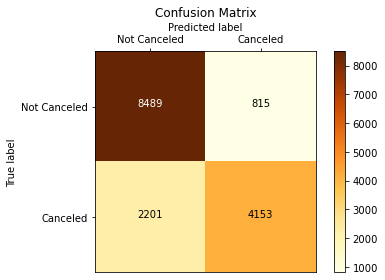

In [96]:
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_testH, log_reg_result)))
print("%-12s %f" % ('Precision:', metrics.precision_score(target_testH, log_reg_result, 
                                                          labels = None, pos_label = 1, 
                                                          average = 'binary', 
                                                          sample_weight = None)))
print("%-12s %f" % ('Recall:', metrics.recall_score(target_testH, log_reg_result, labels=None, 
                                                    pos_label = 1, average = 'binary', 
                                                    sample_weight = None)))
print("%-12s %f" % ('F1 Score:', metrics.f1_score(target_testH, log_reg_result, labels=None, 
                                                  pos_label = 1, average = 'binary', 
                                                  sample_weight = None)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_testH, log_reg_result))

#Draws confusion matrix
draw_confusion_matrix(target_testH, log_reg_result,  ['Not Canceled', 'Canceled'])


### Logistic Regression with PCA


I then wanted to see how PCA data affected the logistic regression and if the accuracy improved. 

In [97]:
grid_log.fit(train_pcaH, targetH)


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=LogisticRegression(max_iter=1000, penalty='none'),
             param_grid=[{'C': [0.1, 0.3, 0.5, 1], 'penalty': ['l1', 'l2'],
                          'solver': ['liblinear']}],
             scoring='accuracy')

In [98]:
print("Best Parameters: ", grid_log.best_params_)
print("Best Score: ", grid_log.best_score_)


Best Parameters:  {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score:  0.766253672889802


After doing grid search with the pca data, the best parameters that achieved the highest accuracy score was the same as before, but notice there is a decrease in accuracy on the subsidized training data.

In [99]:
log_regPCA = LogisticRegression(penalty = 'l1', solver = 'liblinear', C = 0.1, max_iter=500)
log_regPCA.fit(train_pcaH, targetH)


LogisticRegression(C=0.1, max_iter=500, penalty='l1', solver='liblinear')

In [100]:
log_reg_resultPCA = log_regPCA.predict(test_pcaH)


Accuracy:    0.768106
Precision:   0.758594
Recall:      0.628580
F1 Score:    0.687495
Confusion Matrix: 
 [[8033 1271]
 [2360 3994]]


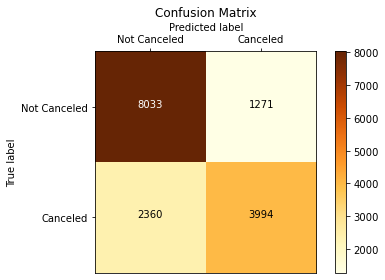

In [101]:
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_testH, log_reg_resultPCA)))
print("%-12s %f" % ('Precision:', metrics.precision_score(target_testH, log_reg_resultPCA, 
                                                          labels = None, pos_label = 1, 
                                                          average = 'binary', 
                                                          sample_weight = None)))
print("%-12s %f" % ('Recall:', metrics.recall_score(target_testH, log_reg_resultPCA, 
                                                    labels=None, 
                                                    pos_label = 1, average = 'binary', 
                                                    sample_weight = None)))
print("%-12s %f" % ('F1 Score:', metrics.f1_score(target_testH, log_reg_resultPCA, 
                                                  labels=None, 
                                                  pos_label = 1, average = 'binary', 
                                                  sample_weight = None)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_testH, log_reg_resultPCA))

#Draws confusion matrix
draw_confusion_matrix(target_testH, log_reg_resultPCA,  ['Not Canceled', 'Canceled'])


Combining the PCA with the logistic regression, we see that it performs worse than just the regular logistic regression.

### KNN

I then decided to use a KNN since this model is also fairly familiar to me and I wanted to see if a non-parametric method would be better to predict if a booking would be canceled or not. 

In [102]:
print(target_test.shape, predicted.shape)


(122,) (114,)


In [103]:
print(train_pipeH.shape, targetH.shape)


(62632, 55) (62632,)


In [104]:
num_samples = len(hotels)
k_neighbours = int(math.sqrt(num_samples))
k_neighbours


279

In [105]:
# KNN
'''
KNN_parameters = [
    {"n_neighbors": [100, 200, 279, 300, 500]},
]
'''

'''
KNN_parameters = [
    {"n_neighbors": [21, 31, 51, 81, 99]},
]
'''

KNN_parameters = [
    {"n_neighbors": [5, 7, 9, 15, 21]},
]

k_KNN = 3
kf_KNN = KFold(n_splits = k_KNN, random_state = None)

KNN = KNeighborsClassifier()

grid_KNN = GridSearchCV(KNN, KNN_parameters, cv = kf_KNN, scoring = "accuracy")
grid_KNN.fit(train_pipeH, targetH)


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [5, 7, 9, 15, 21]}],
             scoring='accuracy')

I performed three different tests for KNN. I saw that for the first test, they choose 100 neighbours. Because of this, for the second test, I choose ranges from 21 up to 99 as I wanted odd numbers to prevent confusion for even neignbours in this regression method. Since the most accurate neighbours was 21, we choose neighbours from 5 all the way up to 21 to see which number of neighbours would be the best. 

In [106]:
print("Best Parameters: ", grid_KNN.best_params_)
print("Best Score: ", grid_KNN.best_score_)


Best Parameters:  {'n_neighbors': 21}
Best Score:  0.832545639765816


In [107]:
KNN_model = KNeighborsClassifier(n_neighbors = 9)
KNN_model.fit(train_pipeH, targetH)


KNeighborsClassifier(n_neighbors=9)

Accuracy:    0.837399
Precision:   0.749134
Recall:      0.833333
F1 Score:    0.788994


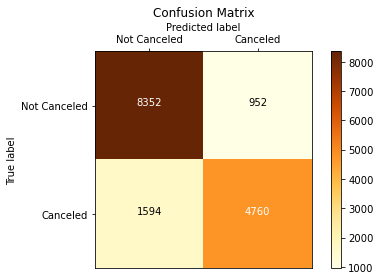

In [108]:
predicted_KNN = KNN_model.predict(test_pipeH)
print("%-12s %f" % ('Accuracy: ', metrics.accuracy_score(predicted_KNN, target_testH)))
print("%-12s %f" % ('Precision:', metrics.precision_score(predicted_KNN, target_testH)))
print("%-12s %f" % ('Recall:', metrics.recall_score(predicted_KNN, target_testH)))
print("%-12s %f" % ('F1 Score:', metrics.f1_score(predicted_KNN, target_testH)))

#Draws confusion matrix
draw_confusion_matrix(target_testH, predicted_KNN,  ['Not Canceled', 'Canceled'])


### KNN with PCA

Like before, I wanted to see if the PCA data would improve the accuracy of the KNN data, so I trained the KNN model on the PCA data.

In [109]:
grid_KNN.fit(train_pcaH, targetH)


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [5, 7, 9, 15, 21]}],
             scoring='accuracy')

In [110]:
print("Best Parameters: ", grid_KNN.best_params_)
print("Best Score: ", grid_KNN.best_score_)


Best Parameters:  {'n_neighbors': 7}
Best Score:  0.8206028420011692


After running grid search of KNN on the PCA data, we see that the most accurate model is still using a k-neighbour of 7. 

In [111]:
KNN_modelPCA = KNeighborsClassifier(n_neighbors = 5)
KNN_modelPCA.fit(train_pcaH, targetH)


KNeighborsClassifier()

Accuracy:    0.831332
Precision:   0.743626
Recall:      0.823601
F1 Score:    0.781573


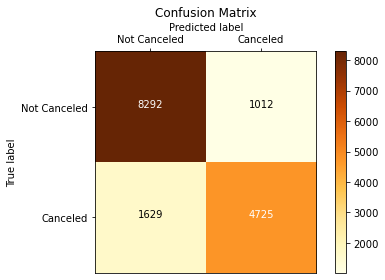

In [112]:
predicted_KNNPCA = KNN_modelPCA.predict(test_pcaH)
print("%-12s %f" % ('Accuracy: ', metrics.accuracy_score(predicted_KNNPCA, target_testH)))
print("%-12s %f" % ('Precision:', metrics.precision_score(predicted_KNNPCA, target_testH)))
print("%-12s %f" % ('Recall:', metrics.recall_score(predicted_KNNPCA, target_testH)))
print("%-12s %f" % ('F1 Score:', metrics.f1_score(predicted_KNNPCA, target_testH)))

#Draws confusion matrix
draw_confusion_matrix(target_testH, predicted_KNNPCA,  ['Not Canceled', 'Canceled'])


Combining KNN with the PCA data, the model does not seem to improve at all, so therefore we will continue to use the regular KNN model. 

### Decision Tree

For my last model, I wanted to use a decision tree as decision trees are supervised learning algorithms that would provide an easier interpretability compared to a MLP, and would also run and train faster. I didn't want to use a SVM as that would require me to find some sort of linear boundary, hard or soft, that may be too long to train as we have a lot of dimensions on our data and would probably further require a kernel trick in order to come up with a predicted model that is accurate. Like what professor said in class, the simplier a model, the easier it is to understand and more favorable due to it's interpretability. 

In [113]:
# decision tree
# Define the parameter grid
param_grid = {
    'max_depth': [1, 3, 5, 10, 20, 100],
    'min_samples_split': [2, 4, 6, 8],
    'criterion': ["gini", "entropy"]
}

# Create the Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state = 0)

k = 3
kf = KFold(n_splits = k, random_state = None)
# you did not do the Kfold before 

# Perform GridSearchCV
grid_decisionTree = GridSearchCV(
    dt_classifier,
    param_grid,
    cv= kf,  # 3-fold cross-validation
    scoring='accuracy'  # evaluation metric
)

# Fit the data to find the best parameters
grid_decisionTree.fit(train_pipeH, targetH)


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 3, 5, 10, 20, 100],
                         'min_samples_split': [2, 4, 6, 8]},
             scoring='accuracy')

In [114]:
# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)


Best Parameters:  {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 8}
Best Score:  0.7681238615664846


After using grid search on a Decision Tree, we see that the optimal parameters that gives us the highest accuracy are entropy criterion with a max depth of 4 and split of 8. The max depth of 4 means that it will only go up to 4 splits of the decision tree in order to predict whether a sample given some characteristics would be canceled or not. The criterion of entropy means that it will choose the features that reduce uncertainty. The min_samples_split indicates how much samples are needed to split a node. 

In [115]:
decisionTree_class = DecisionTreeClassifier(criterion = 'entropy', max_depth = 4, 
                                            min_samples_split = 8, random_state = 0)

decisionTree_class.fit(train_pipeH, targetH)


DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_split=8,
                       random_state=0)

Accuracy:    0.789309
Precision:   0.748092
Recall:      0.724898
F1 Score:    0.736312
Confusion Matrix: 
 [[7753 1551]
 [1748 4606]]


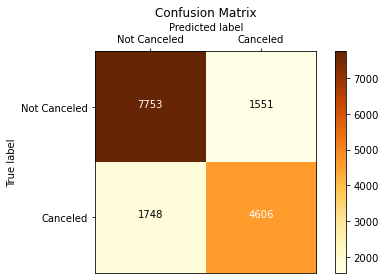

In [116]:
decisionTree_predicted = decisionTree_class.predict(test_pipeH)

print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_testH, 
                                                        decisionTree_predicted)))
print("%-12s %f" % ('Precision:', metrics.precision_score(target_testH,
                                                          decisionTree_predicted, 
                                                          labels = None, pos_label = 1, 
                                                          average = 'binary', 
                                                          sample_weight = None)))
print("%-12s %f" % ('Recall:', metrics.recall_score(target_testH, decisionTree_predicted, 
                                                    labels=None, pos_label = 1, 
                                                    average = 'binary', 
                                                    sample_weight = None)))
print("%-12s %f" % ('F1 Score:', metrics.f1_score(target_testH, decisionTree_predicted, 
                                                  labels=None, pos_label = 1, 
                                                  average = 'binary', sample_weight = None)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_testH, decisionTree_predicted))

#Draws confusion matrix
draw_confusion_matrix(target_testH, decisionTree_predicted,  ['Not Canceled', 'Canceled'])


### Decision Tree with PCA

In [117]:
grid_decisionTree.fit(train_pcaH, targetH)


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 3, 5, 10, 20, 100],
                         'min_samples_split': [2, 4, 6, 8]},
             scoring='accuracy')

In [118]:
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)


Best Parameters:  {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 8}
Best Score:  0.7681238615664846


In [119]:
decisionTree_classPCA = DecisionTreeClassifier(criterion = 'entropy', max_depth = 4, 
                                            min_samples_split = 8, random_state = 0)

decisionTree_classPCA.fit(train_pcaH, targetH)

DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_split=8,
                       random_state=0)

Accuracy:    0.757887
Precision:   0.738774
Recall:      0.624016
F1 Score:    0.676563
Confusion Matrix: 
 [[7902 1402]
 [2389 3965]]


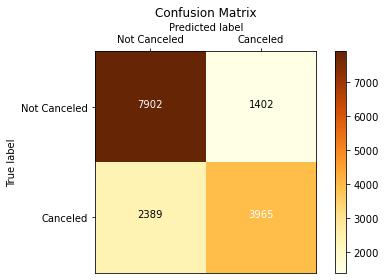

In [120]:
decisionTree_predictedPCA = decisionTree_classPCA.predict(test_pcaH)

print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_testH, 
                                                        decisionTree_predictedPCA)))
print("%-12s %f" % ('Precision:', metrics.precision_score(target_testH, 
                                                          decisionTree_predictedPCA, 
                                                          labels = None, pos_label = 1, 
                                                          average = 'binary', 
                                                          sample_weight = None)))
print("%-12s %f" % ('Recall:', metrics.recall_score(target_testH, decisionTree_predictedPCA, 
                                                    labels=None, pos_label = 1, 
                                                    average = 'binary', 
                                                    sample_weight = None)))
print("%-12s %f" % ('F1 Score:', metrics.f1_score(target_testH, decisionTree_predictedPCA, 
                                                  labels=None, pos_label = 1, 
                                                  average = 'binary', sample_weight = None)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_testH, 
                                                       decisionTree_predictedPCA))

#Draws confusion matrix
draw_confusion_matrix(target_testH, decisionTree_predictedPCA,  ['Not Canceled', 'Canceled'])


#### MLP

I had time to implement an MLP model, so I will try that as well. I think that if the model follows a non-linear pattern, it would be able to solve this complex pattern. I choose MLP as the logistic regression would've found a linear pattern in the model and compared to SVM, I think the SVM would've only increased the accuracy by a small amount.

In [121]:
# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(100, ),],
    'activation' : ['relu', 'logistic'],
    'solver' : ['adam', 'lbfgs', 'sgd'],
    'alpha': [0.0001, 0.00001, 0.000001],
    'max_iter': [800]
}

# Create the Decision Tree classifier
MLP_classifier = MLPClassifier(random_state = 0)

k = 3
kf = KFold(n_splits = k, random_state = None)
# you did not do the Kfold before 

# Perform GridSearchCV
grid_search = GridSearchCV(
    MLP_classifier,
    param_grid,
    cv= kf,  # 3-fold cross-validation
    scoring='accuracy'  # evaluation metric
)

# Fit the data to find the best parameters
grid_search.fit(train_pipeH, targetH)


/Users/aaron/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/aaron/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/aaron/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converg

/Users/aaron/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/aaron/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/aaron/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converg

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=MLPClassifier(random_state=0),
             param_grid={'activation': ['relu', 'logistic'],
                         'alpha': [0.0001, 1e-05, 1e-06],
                         'hidden_layer_sizes': [(100,)], 'max_iter': [800],
                         'solver': ['adam', 'lbfgs', 'sgd']},
             scoring='accuracy')

In [122]:
# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)


Best Parameters:  {'activation': 'relu', 'alpha': 1e-05, 'hidden_layer_sizes': (100,), 'max_iter': 800, 'solver': 'sgd'}
Best Score:  0.8548345467019817


In [123]:
MLP_model = MLPClassifier(activation = 'relu', alpha = 0.00001, hidden_layer_sizes = (100, ),
                         max_iter = 800, solver = 'sgd')

MLP_model.fit(train_pipeH, targetH)


MLPClassifier(alpha=1e-05, max_iter=800, solver='sgd')

Accuracy:    0.857198
Precision:   0.855245
Recall:      0.780138
F1 Score:    0.815967
Confusion Matrix: 
 [[8465  839]
 [1397 4957]]


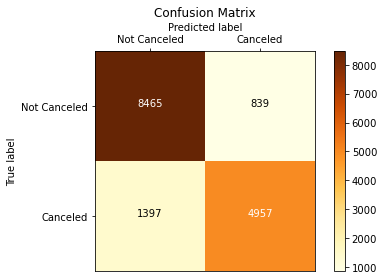

In [124]:
decisionTree_predictedMLP = MLP_model.predict(test_pipeH)

print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_testH, 
                                                        decisionTree_predictedMLP)))
print("%-12s %f" % ('Precision:', metrics.precision_score(target_testH, 
                                                          decisionTree_predictedMLP, 
                                                          labels = None, pos_label = 1, 
                                                          average = 'binary', 
                                                          sample_weight = None)))
print("%-12s %f" % ('Recall:', metrics.recall_score(target_testH, decisionTree_predictedMLP, 
                                                    labels=None, pos_label = 1, 
                                                    average = 'binary', 
                                                    sample_weight = None)))
print("%-12s %f" % ('F1 Score:', metrics.f1_score(target_testH, decisionTree_predictedMLP, 
                                                  labels=None, pos_label = 1, 
                                                  average = 'binary', sample_weight = None)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_testH, 
                                                       decisionTree_predictedMLP))

#Draws confusion matrix
draw_confusion_matrix(target_testH, decisionTree_predictedMLP,  ['Not Canceled', 'Canceled'])


## Extra Credit 

We have provided an extra test dataset named "hotel_booking_test.csv" that does not have the target labels. Classify the samples in the dataset with your best model and write them into a csv file. Submit your csv file to our [Kaggle](https://www.kaggle.com/t/ed725123bf124e9199c1d8fdc8a2d9c7) contest. The website will specify your classification accuracy on the test set. We will award a bonus point for the project for every percentage point over 75% that you get on your kaggle test accuracy.

To get the bonus points, you must also write out a summary of the model that you submit including any changes you made to the pre-processing steps. The summary must be written in a markdown cell of the jupyter notebook. Note that you should not change earlier parts of the project to complete the extra credit. 

**Kaggle Submission Instruction**
Submit a two column csv where the first column is named "ID" and is the row number. The second column is named "target" and is the classification for each sample. Make sure that the sample order is preserved.

***Model Choosen:***

Because our MLP model was the most accurate and best performer, we will be using the MLP model that we created with these parameters: activation = 'relu', alpha = 0.00001, hidden_layer_sizes = (100, ), max_iter = 800, solver = 'sgd'

Since we are not changing anything in the model parameters, we do not need to submit any changes. However, we will continue to pipeline the data, drop features we dropped before so the dimensions the model is expecting to receive stays the same, and balance the data by replacing or removing missing values. 

In [125]:
hotel_booking_test = pd.read_csv(
    '/Users/aaron/EC_ENGR_M148/week8/Project 3/datasets/hotel_booking_test.csv')


In [126]:
hotel_booking_test.head()


hotel  lead_time arrival_date_month  stays_in_weekend_nights  \
0    City Hotel        177             August                        0   
1  Resort Hotel        217             August                        2   
2    City Hotel         65          September                        2   
3    City Hotel        377            October                        0   
4    City Hotel         75                May                        2   

   stays_in_week_nights  adults  children  babies meal country  ...  \
0                     2       2       0.0       0   SC     FRA  ...   
1                     5       2       1.0       0   HB     PRT  ...   
2                     1       2       0.0       0   HB     PRT  ...   
3                     2       2       0.0       0   HB     DEU  ...   
4                     1       2       0.0       0   BB     PRT  ...   

   booking_changes  deposit_type days_in_waiting_list    customer_type    adr  \
0                0    No Deposit                    0        Transient   94.5   
1                0    No Deposit                    0        Transient  170.0   
2                0    Non Refund                    0        Transient   86.0   
3                0    No Deposit                    0  Transient-Party  115.0   
4                0    No Deposit                    0  Transient-Party   90.0   

   required_car_parking_spaces total_of_special_requests             name  \
0                            0                         1  Wendy Moore DDS   
1                            0                         0   Brandon Fields   
2                            0                         0      Chad Peters   
3                            0                         1    Colin Rosario   
4                            0                         0       Dana Booth   

                          email  phone-number  
0             Wendy_D50@att.com  350-596-1114  
1              BFields@zoho.com  872-706-9025  
2       Peters.Chad@outlook.com  581-621-8941  
3  Rosario_Colin@protonmail.com  783-552-8468  
4      Dana_Booth22@outlook.com  194-105-9813  

[5 rows x 23 columns]

In [127]:
hotel_booking_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8699 entries, 0 to 8698
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           8699 non-null   object 
 1   lead_time                       8699 non-null   int64  
 2   arrival_date_month              8699 non-null   object 
 3   stays_in_weekend_nights         8699 non-null   int64  
 4   stays_in_week_nights            8699 non-null   int64  
 5   adults                          8699 non-null   int64  
 6   children                        8698 non-null   float64
 7   babies                          8699 non-null   int64  
 8   meal                            8699 non-null   object 
 9   country                         8699 non-null   object 
 10  previous_cancellations          8699 non-null   int64  
 11  previous_bookings_not_canceled  8699 non-null   int64  
 12  reserved_room_type              86

In [128]:
hotel_booking_test.index[hotel_booking_test['children'].isnull()]


Int64Index([3108], dtype='int64')

In [129]:
hotel_booking_test.loc[3108, 'children'] = 0 


In [130]:
hotel_booking_test['children'].isnull().sum()


0

In [131]:
hotel_booking_test.insert(3, 'total_stays', hotel_booking_test['stays_in_weekend_nights'] + 
              hotel_booking_test['stays_in_week_nights'])


In [132]:
le = LabelEncoder()

hotel_booking_test['required_car_parking_spaces'] = le.fit_transform(
    hotel_booking_test['required_car_parking_spaces'])

hotel_booking_test['total_of_special_requests'] = le.fit_transform(
    hotel_booking_test['total_of_special_requests'])


In [133]:
hotel_booking_test = hotel_booking_test.drop(
    ['name', 'email', 'phone-number'], axis = 1)


In [134]:
hotel_booking_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8699 entries, 0 to 8698
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           8699 non-null   object 
 1   lead_time                       8699 non-null   int64  
 2   arrival_date_month              8699 non-null   object 
 3   total_stays                     8699 non-null   int64  
 4   stays_in_weekend_nights         8699 non-null   int64  
 5   stays_in_week_nights            8699 non-null   int64  
 6   adults                          8699 non-null   int64  
 7   children                        8699 non-null   float64
 8   babies                          8699 non-null   int64  
 9   meal                            8699 non-null   object 
 10  country                         8699 non-null   object 
 11  previous_cancellations          8699 non-null   int64  
 12  previous_bookings_not_canceled  86

In [135]:
hotel_booking_test.shape

(8699, 21)

In [136]:
hotel_booking_test_pipe = pipeLine.transform(hotel_booking_test)


In [137]:
hotel_booking_test_pipe.shape

(8699, 55)

After pipelining the data for the testing csv file, it's ready to be used in order to predict if a hotel booking would be canceled or not. In addition to pipelining the data, I also dropped the unnecessary variables and augmented the 'total_stays' data. Since my KNN with a k-neighbour of 7 was the most accurate model, I decided to use that model to predict the data. 

In [138]:
hotel_booking_predict = MLP_model.predict(hotel_booking_test_pipe)


In [139]:
data = {
    'ID': range(0, len(hotel_booking_predict)),
    'target' : hotel_booking_predict
}

submission = pd.DataFrame(data)

In [140]:
submission

ID  target
0        0       1
1        1       1
2        2       1
3        3       0
4        4       1
...    ...     ...
8694  8694       1
8695  8695       1
8696  8696       0
8697  8697       0
8698  8698       0

[8699 rows x 2 columns]

In [141]:
submission.to_csv('final.csv', index = False)
